In [5]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

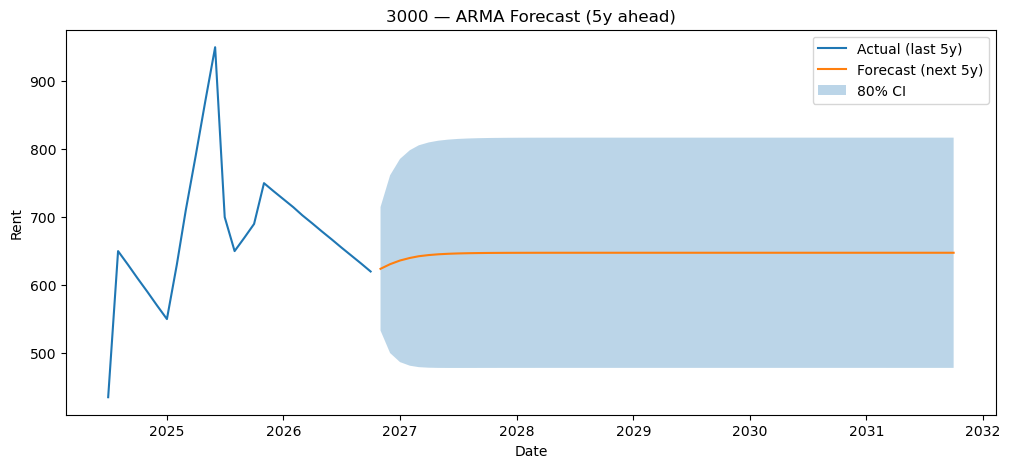

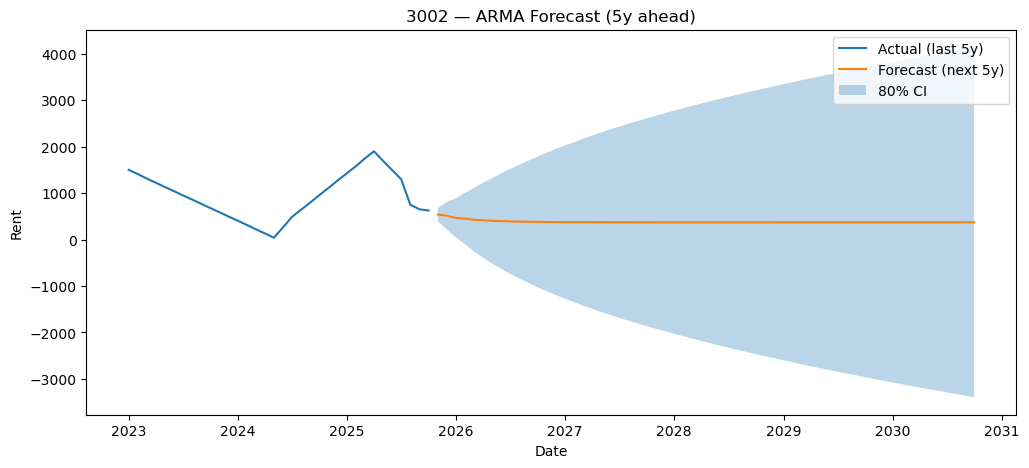

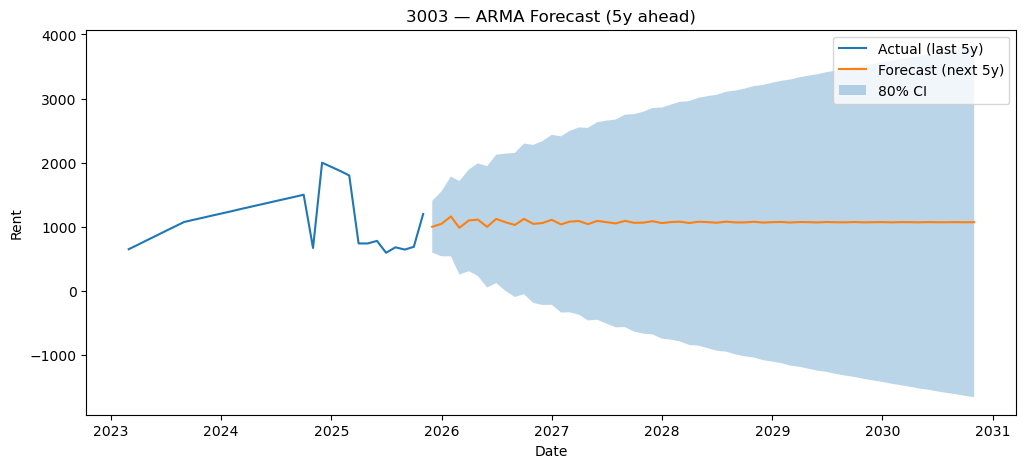

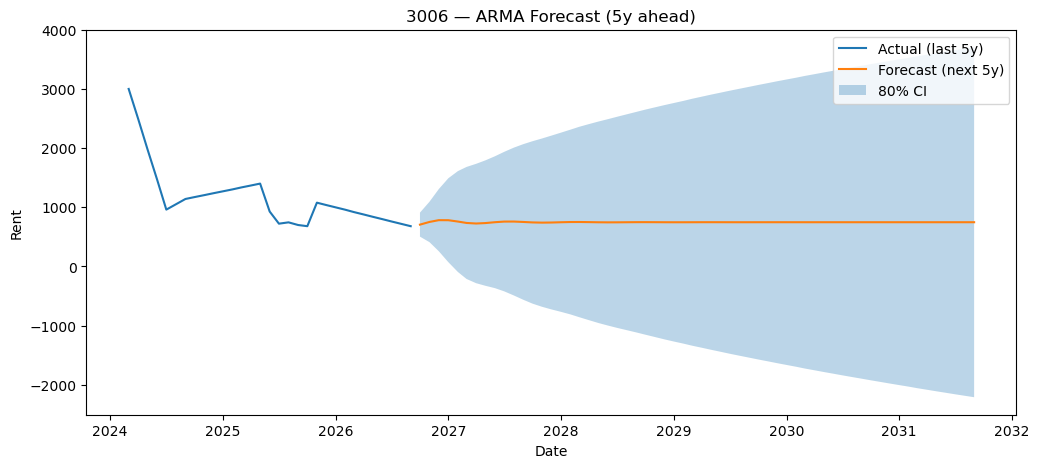

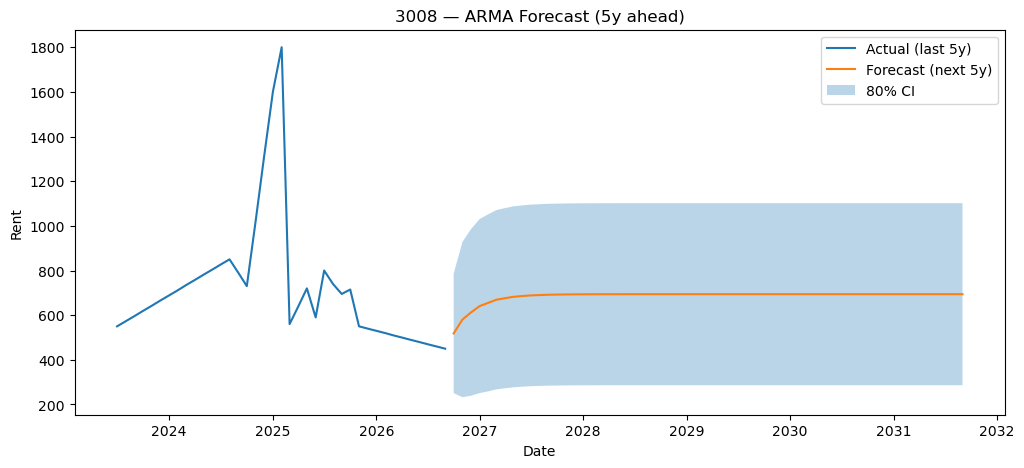

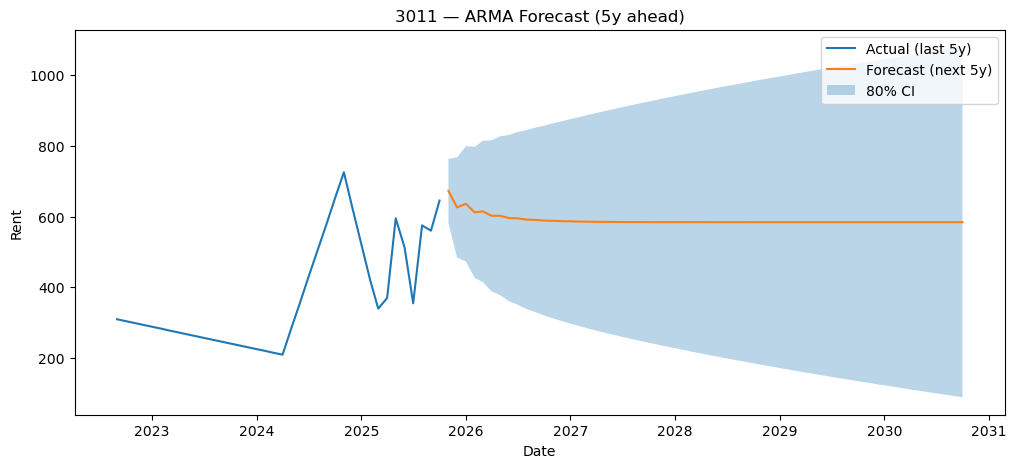

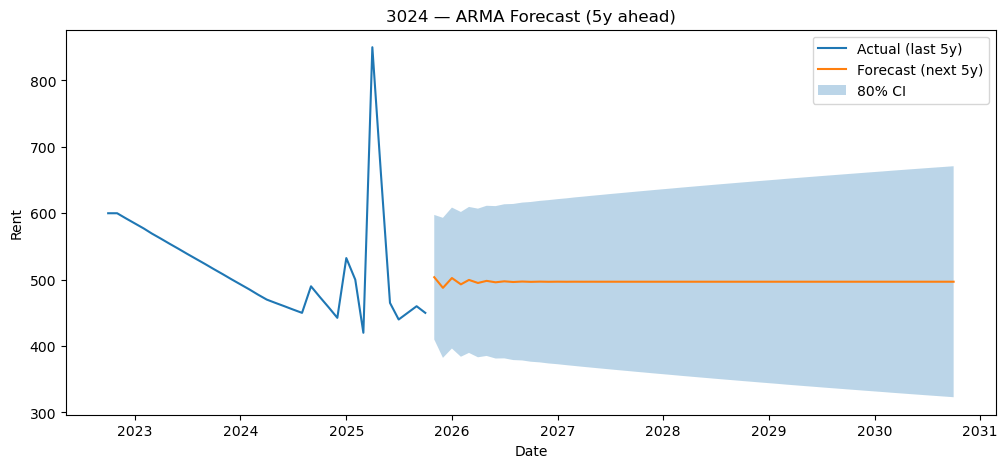

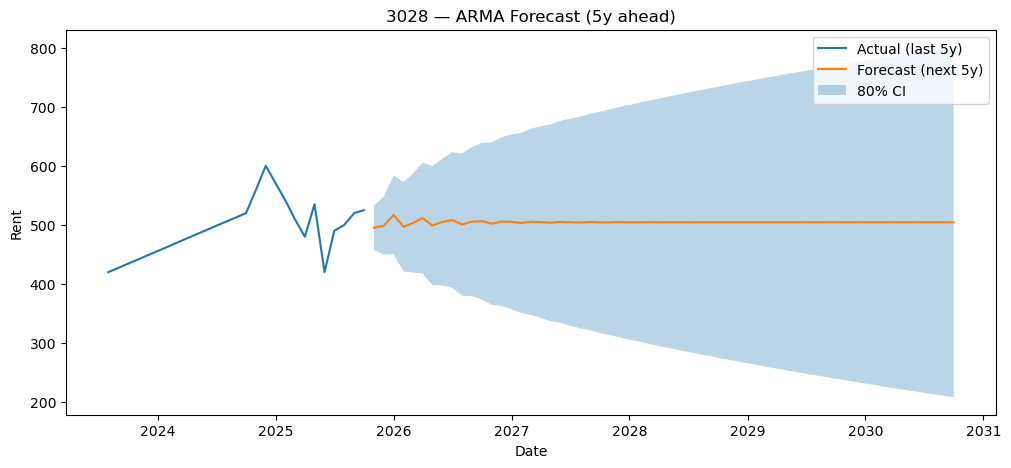

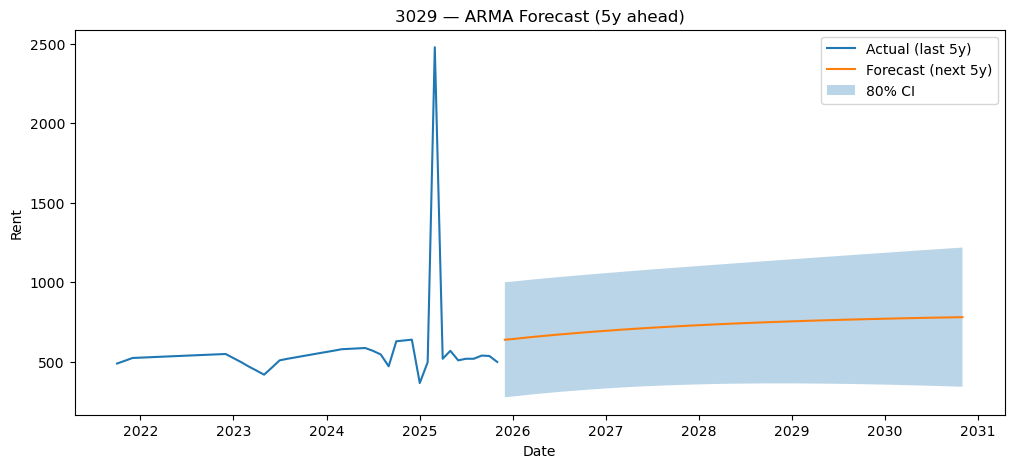

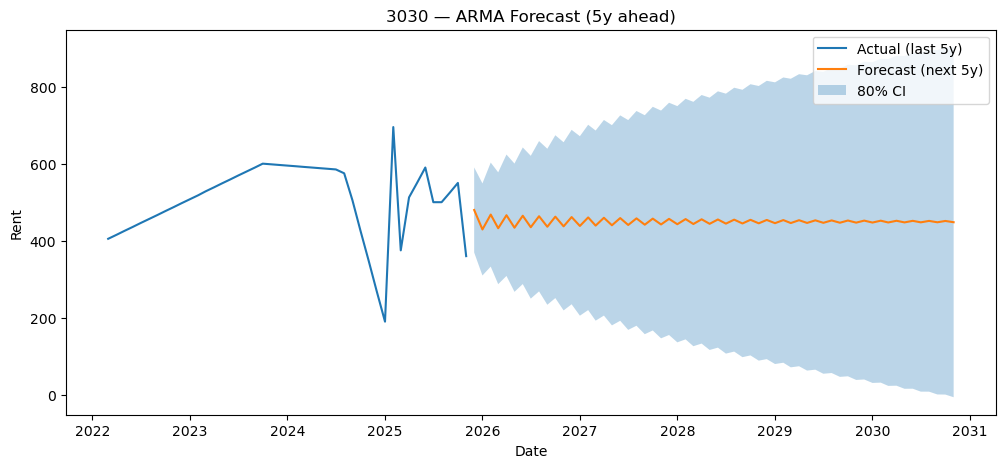

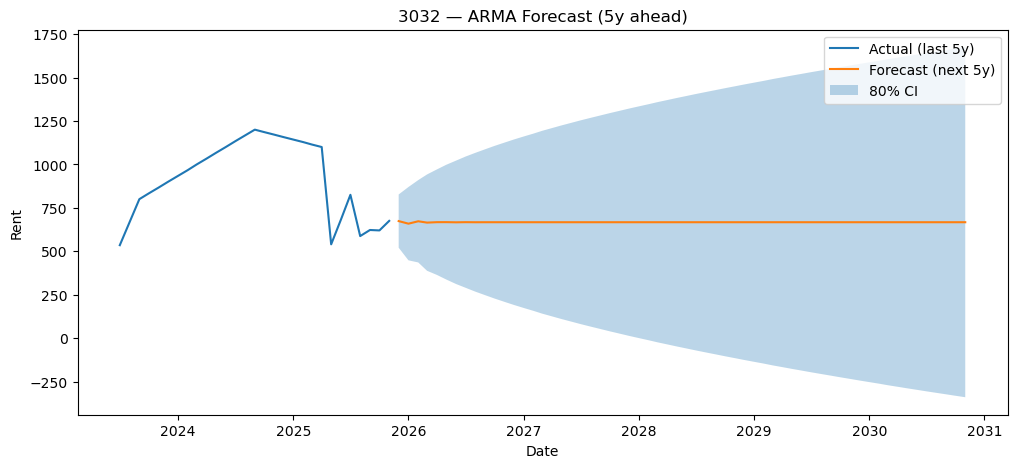

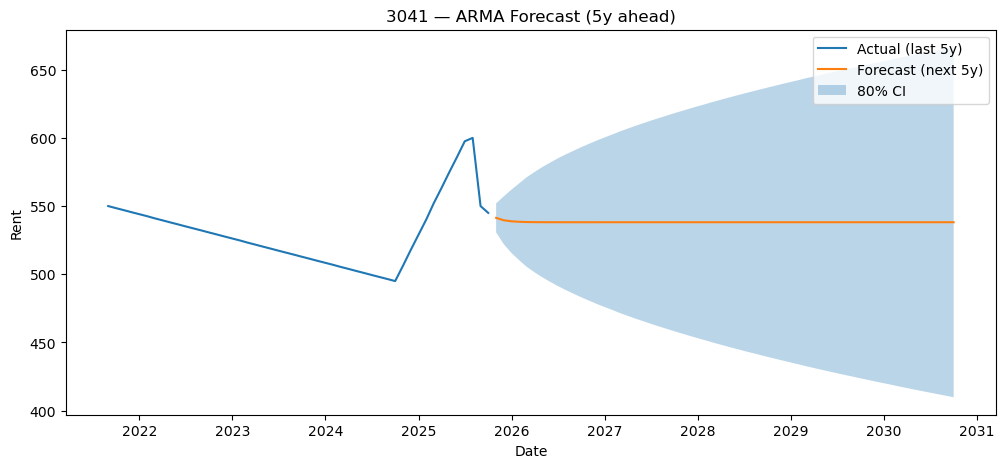

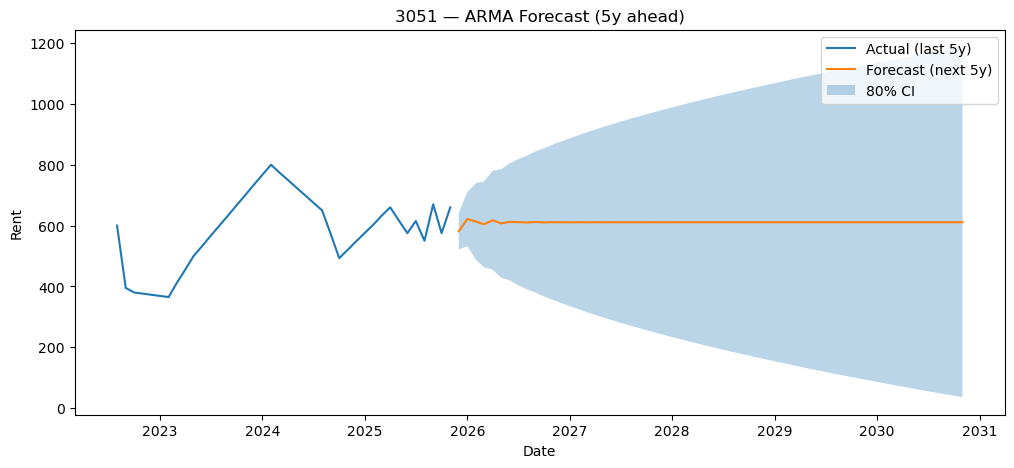

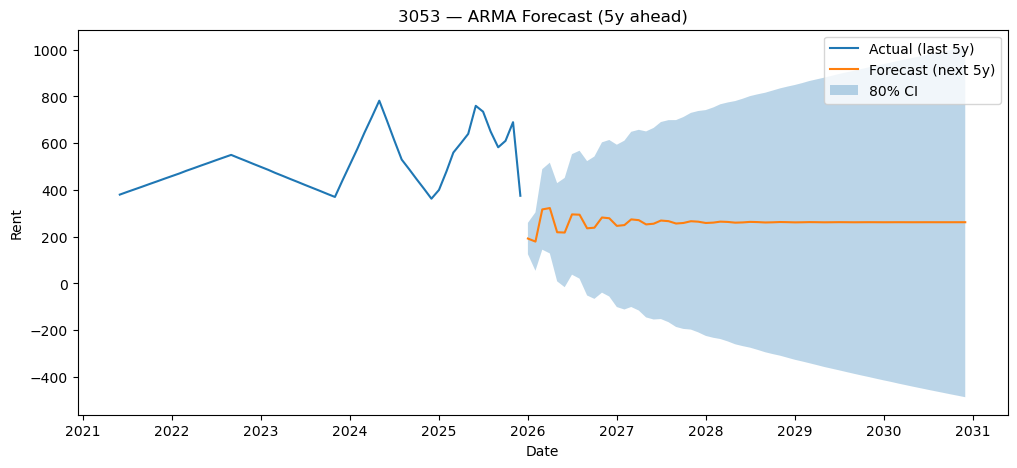

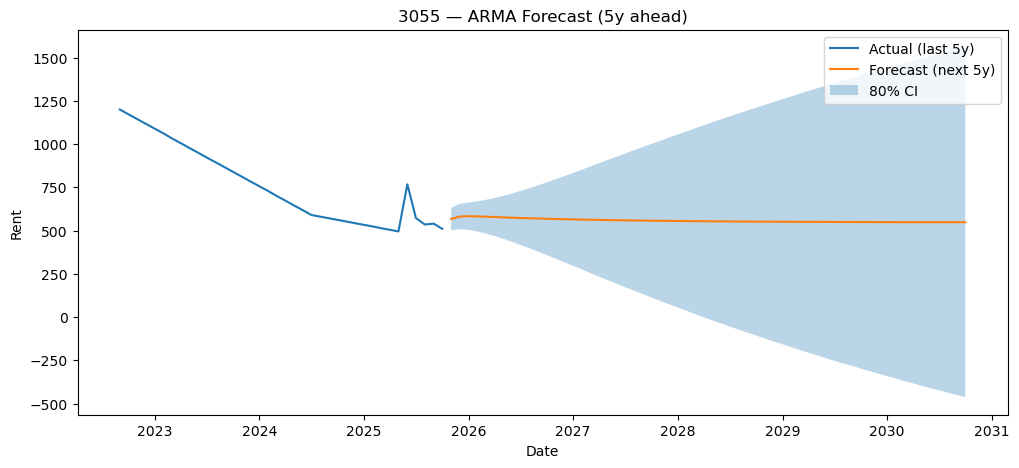

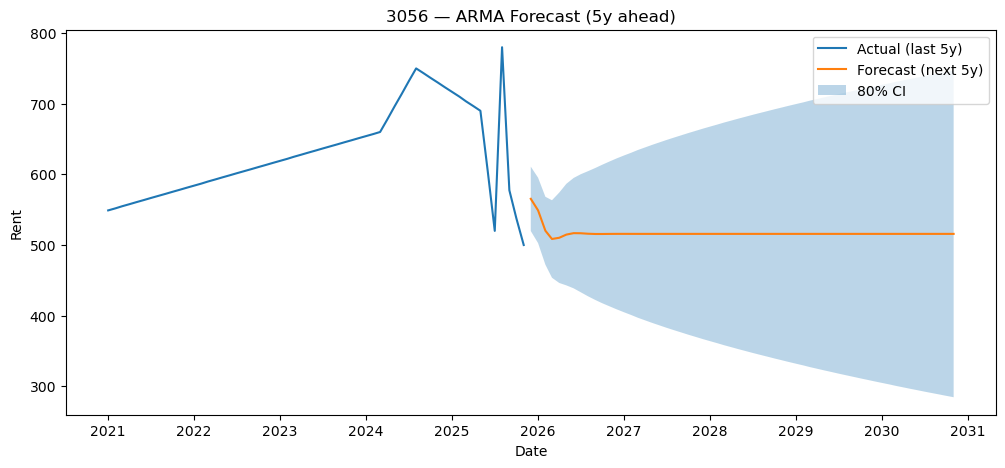

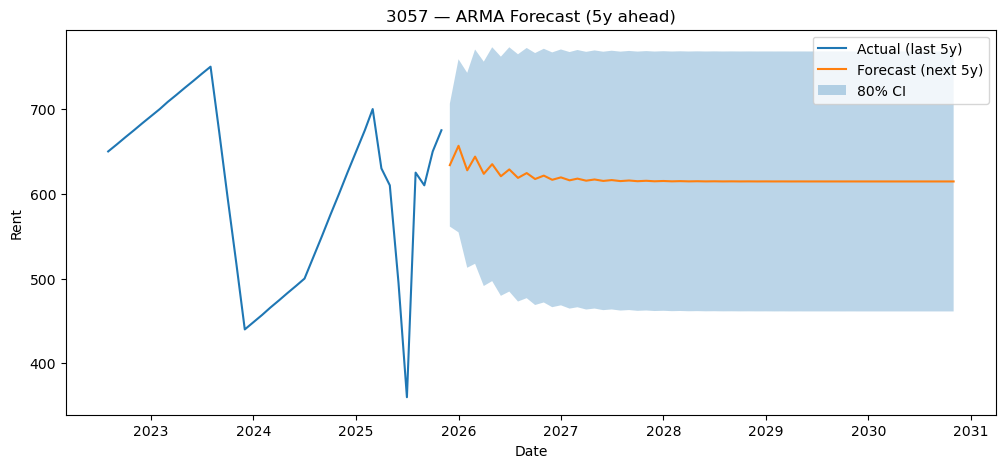

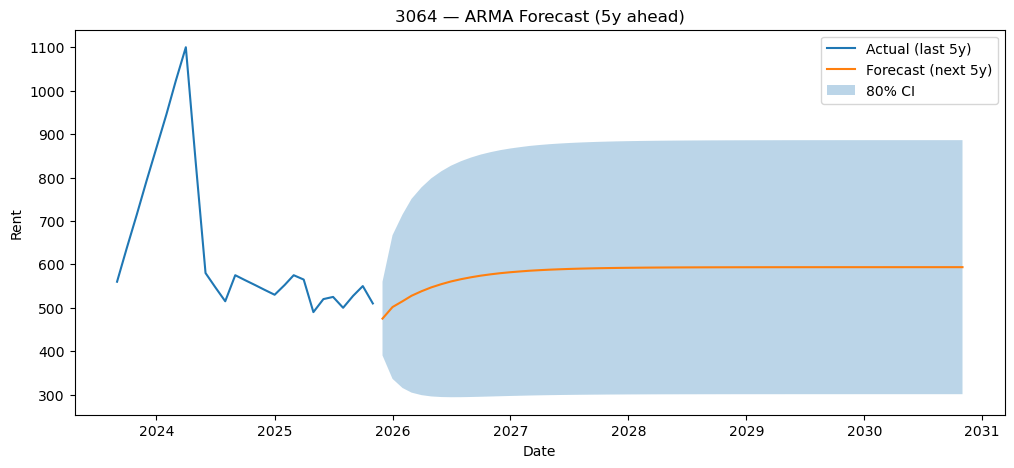

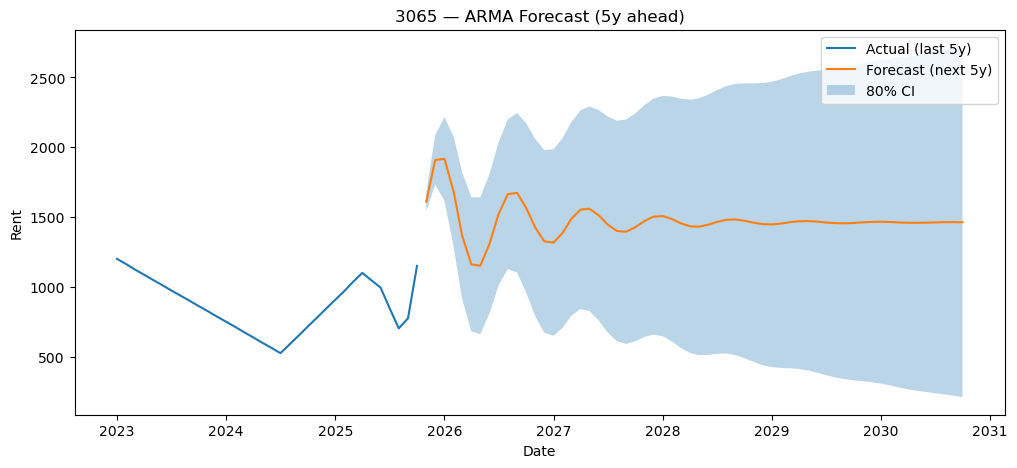

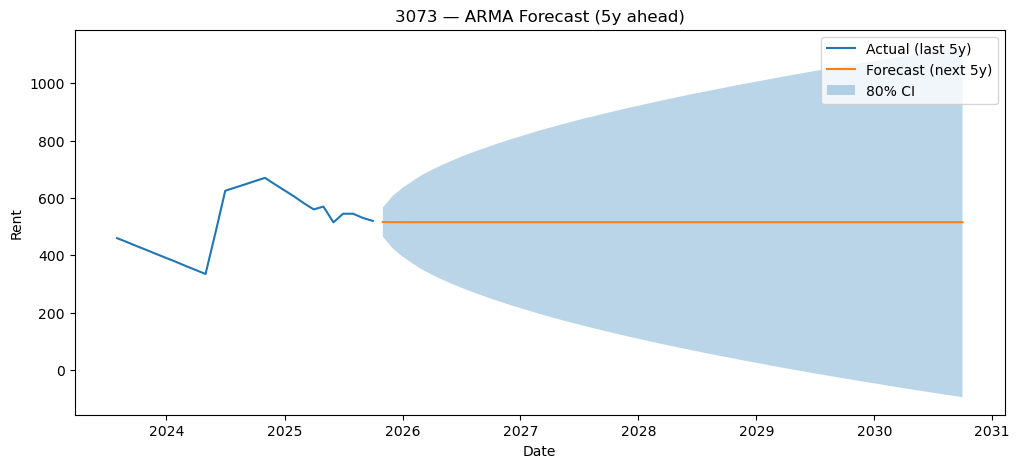

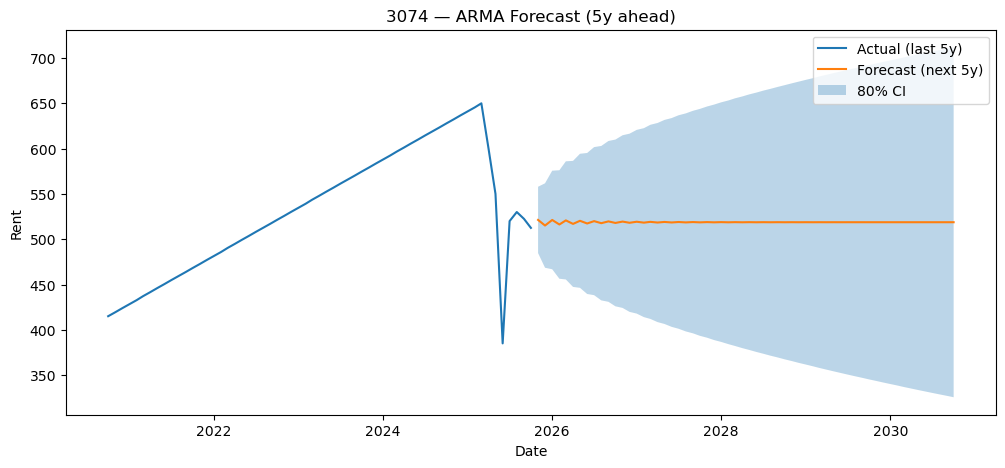

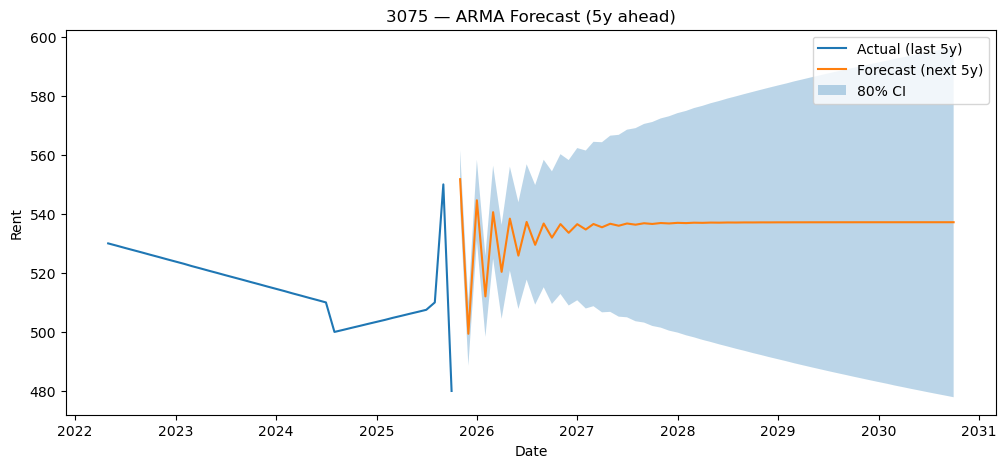

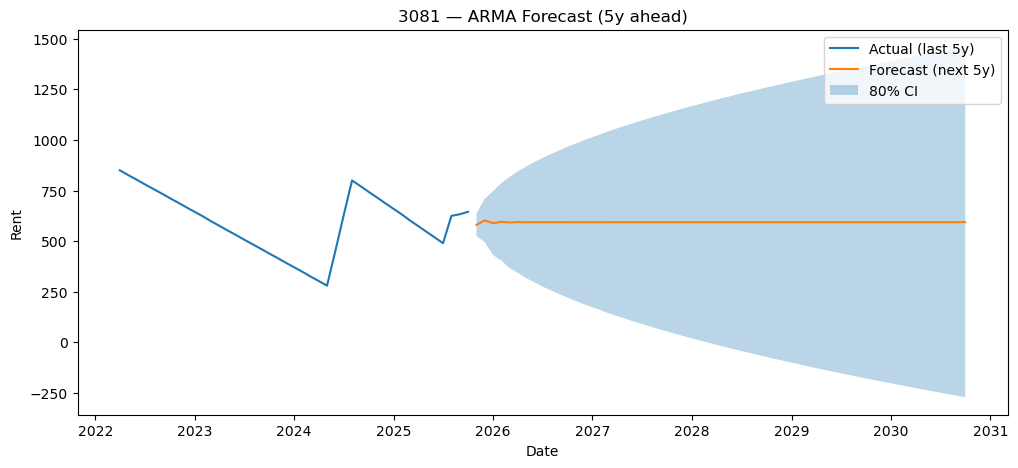

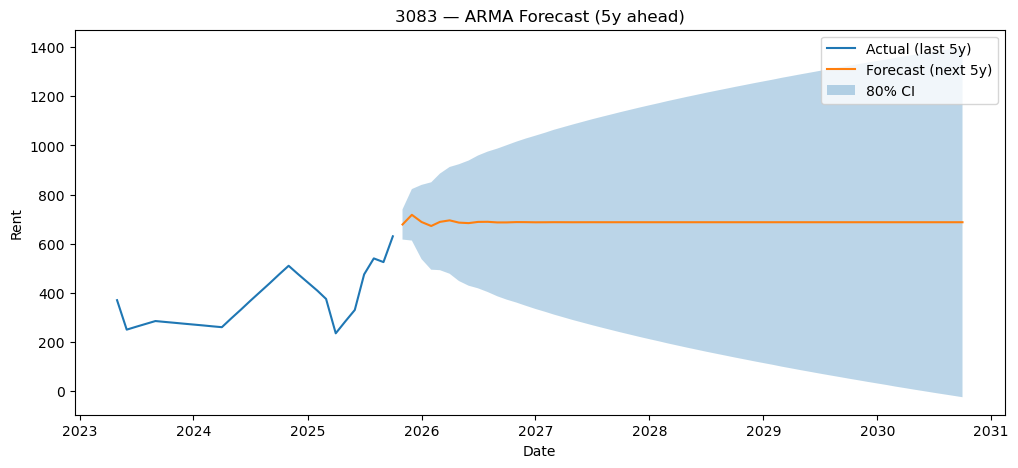

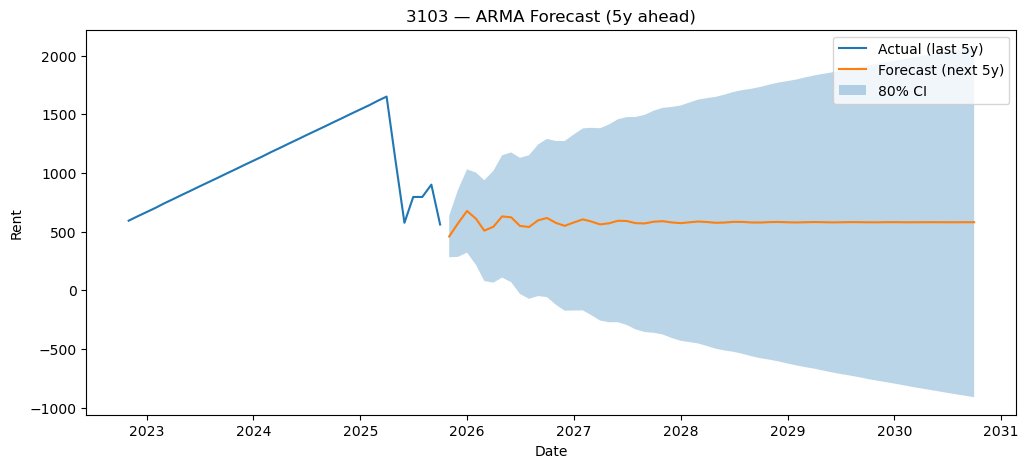

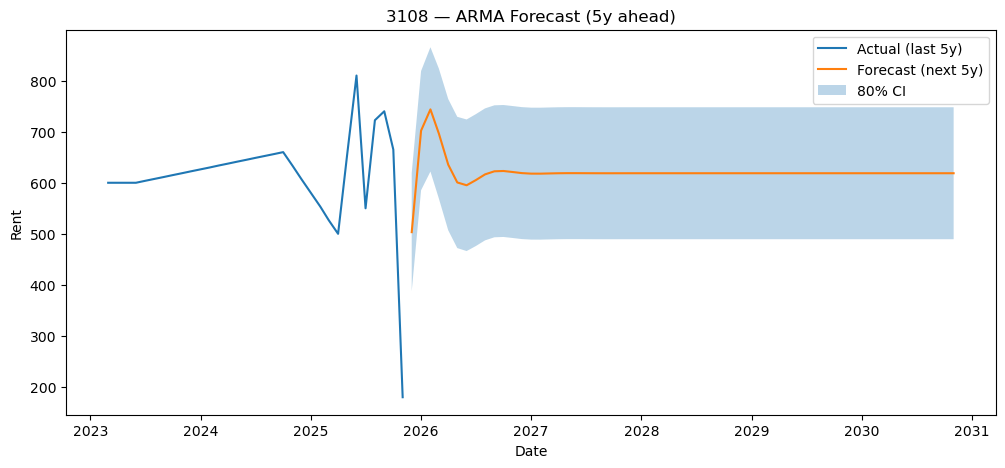

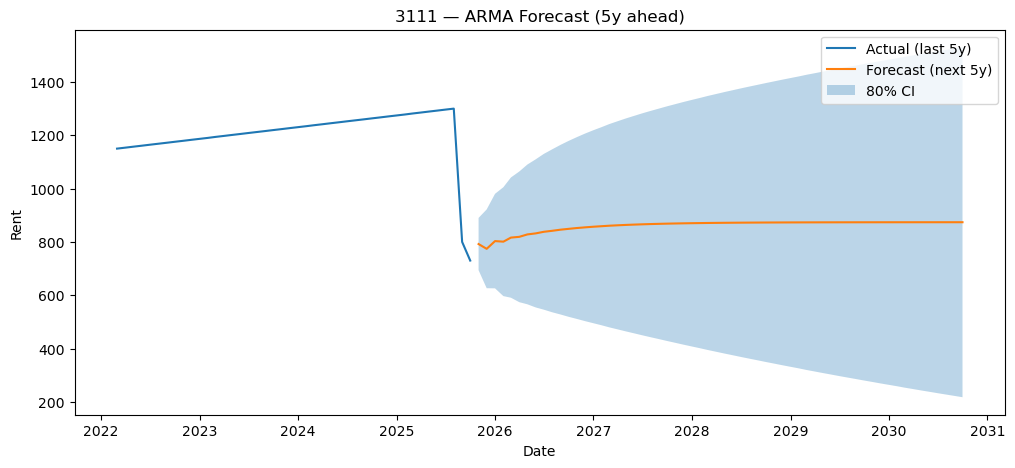

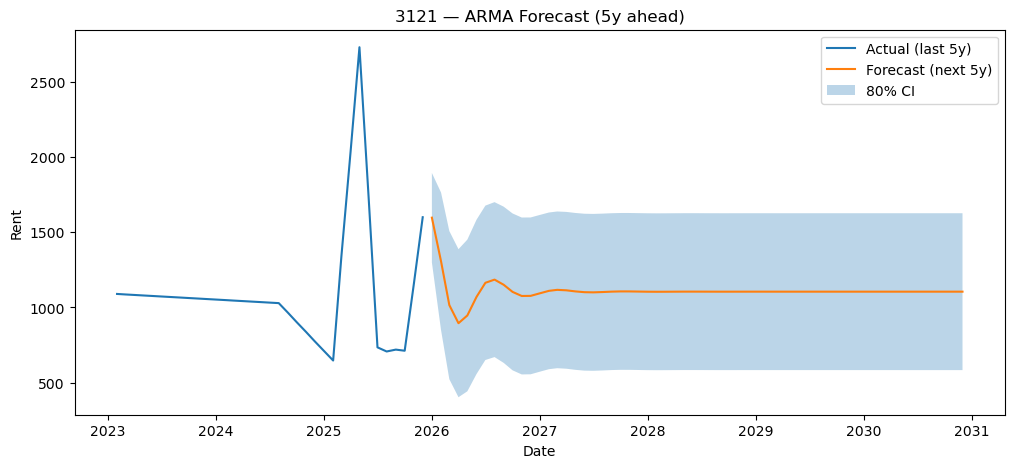

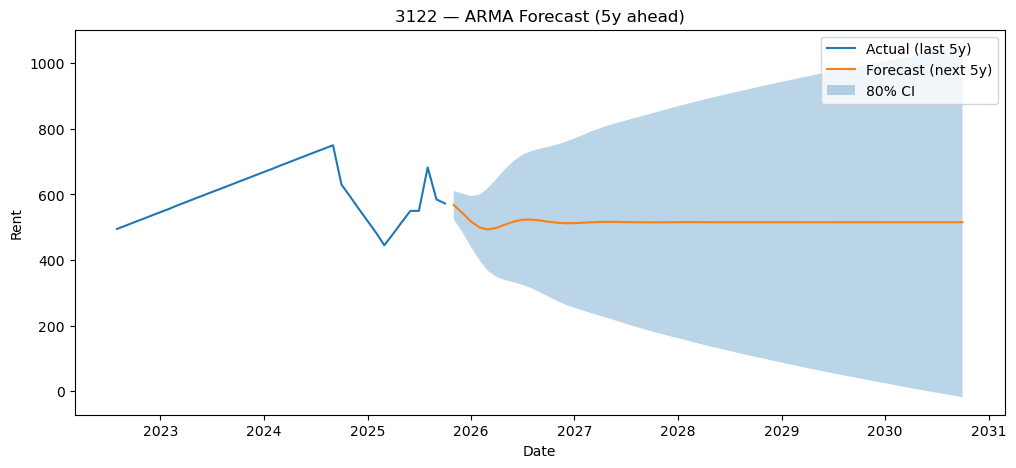

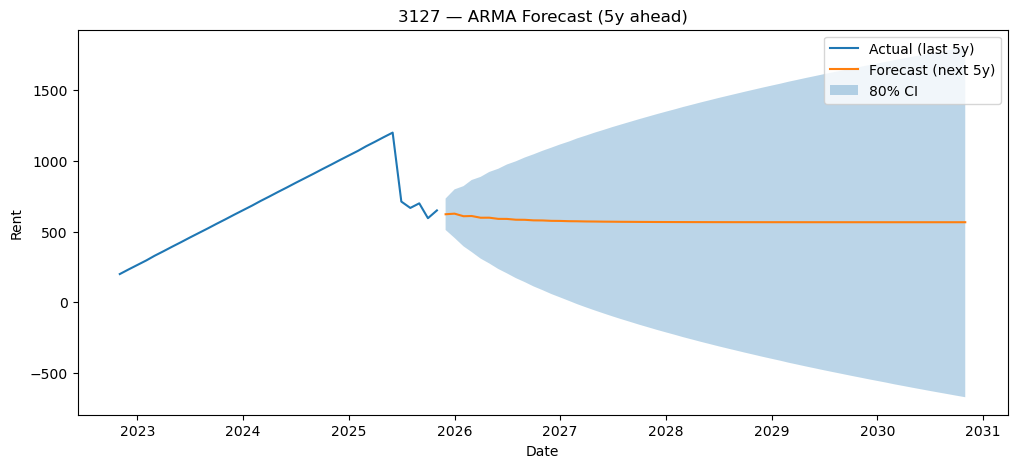

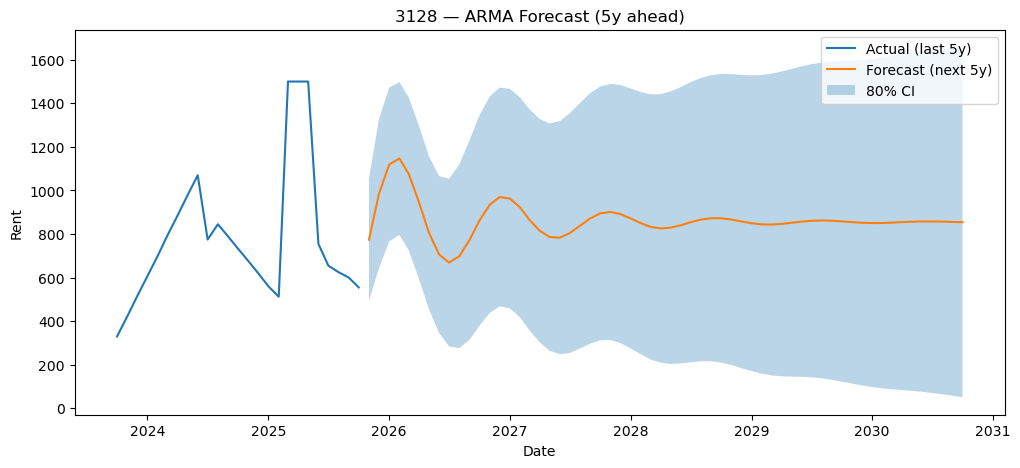

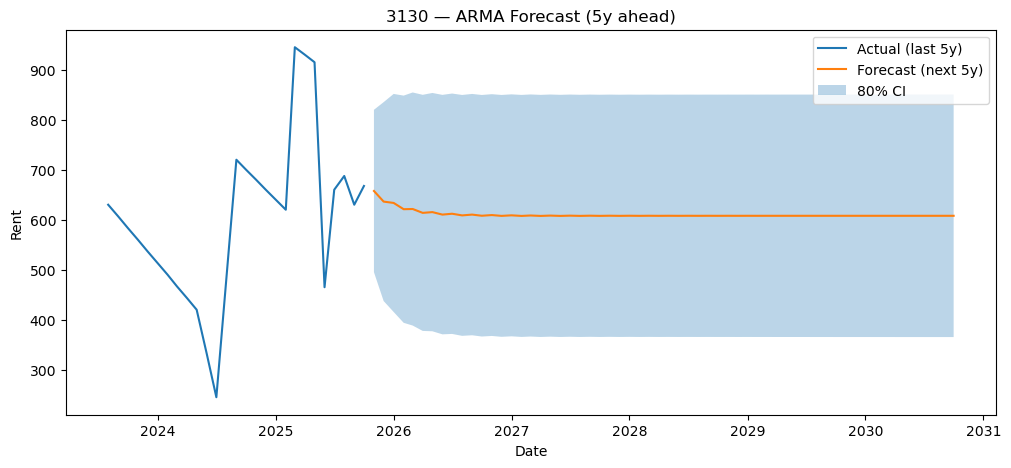

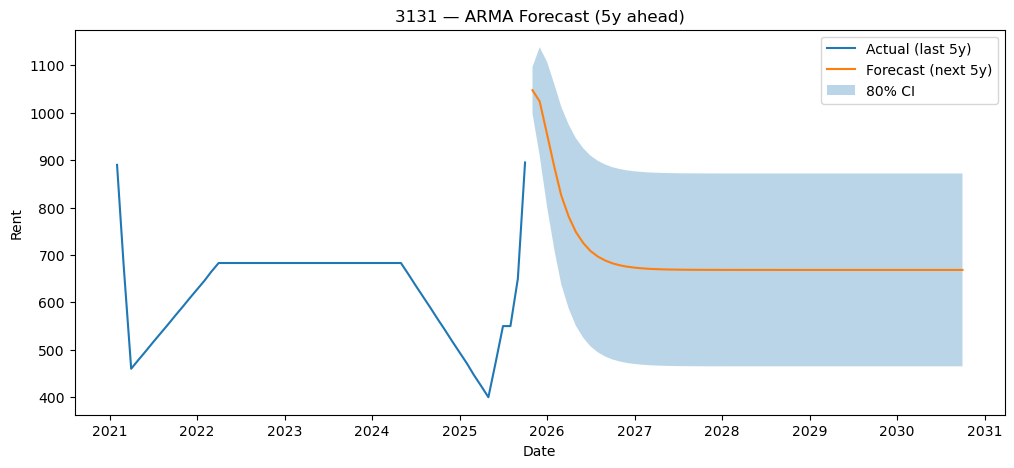

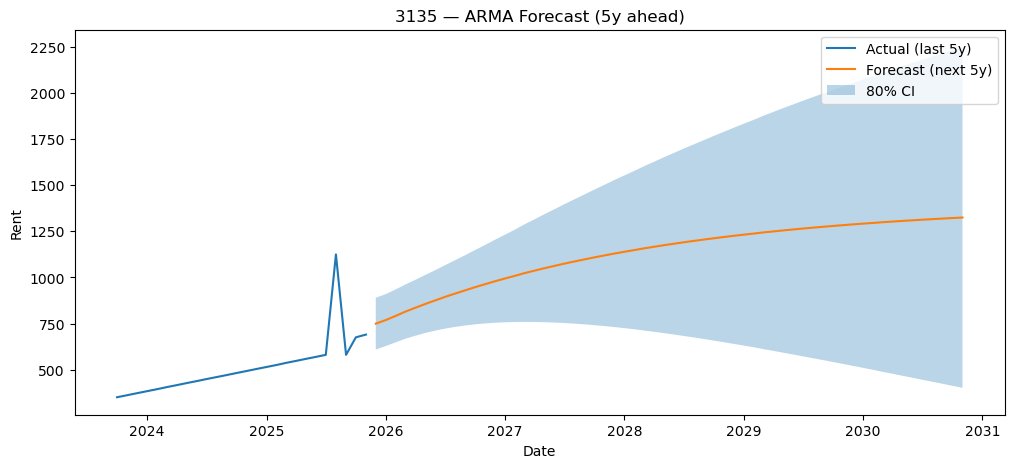

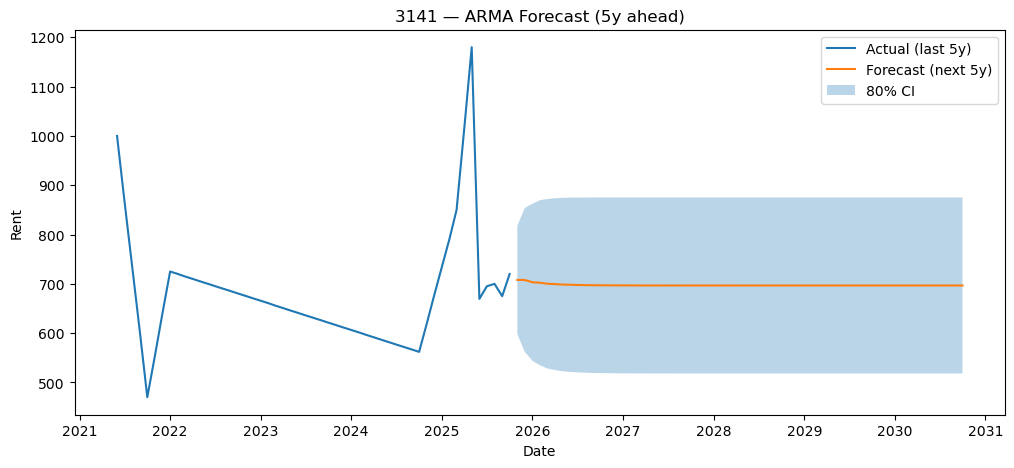

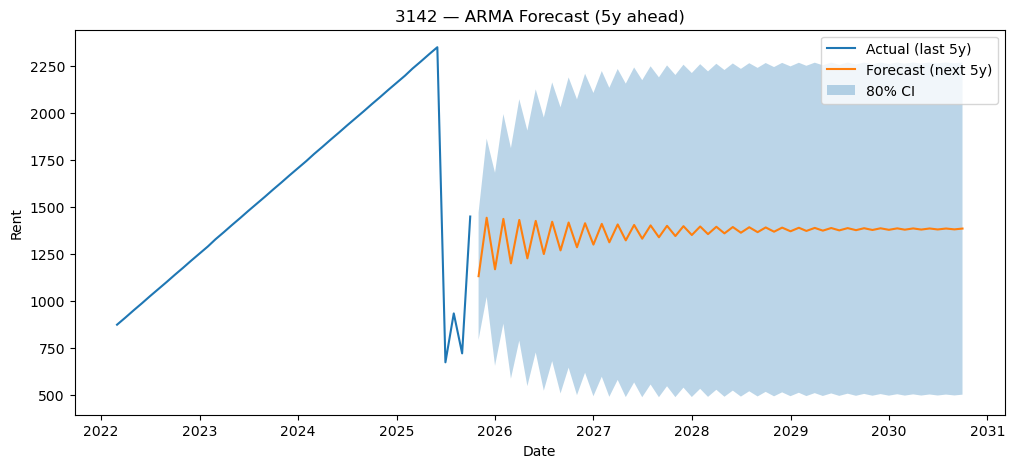

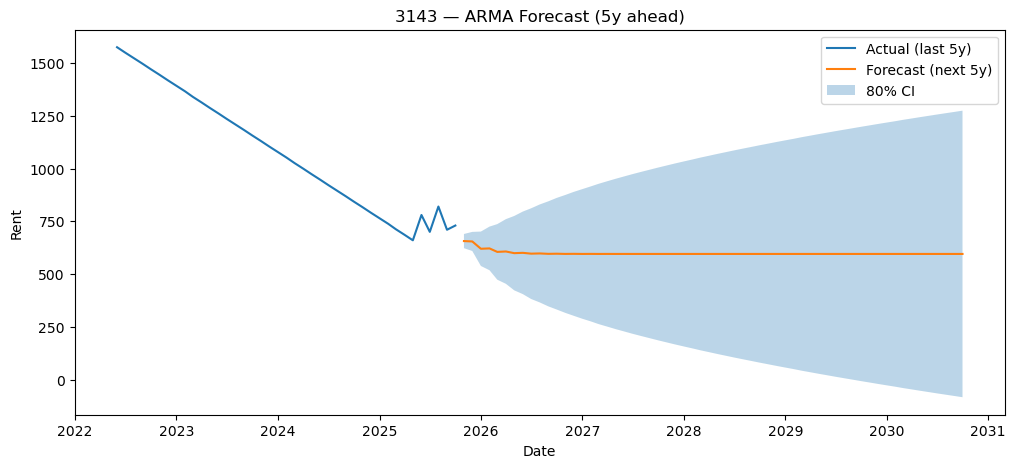

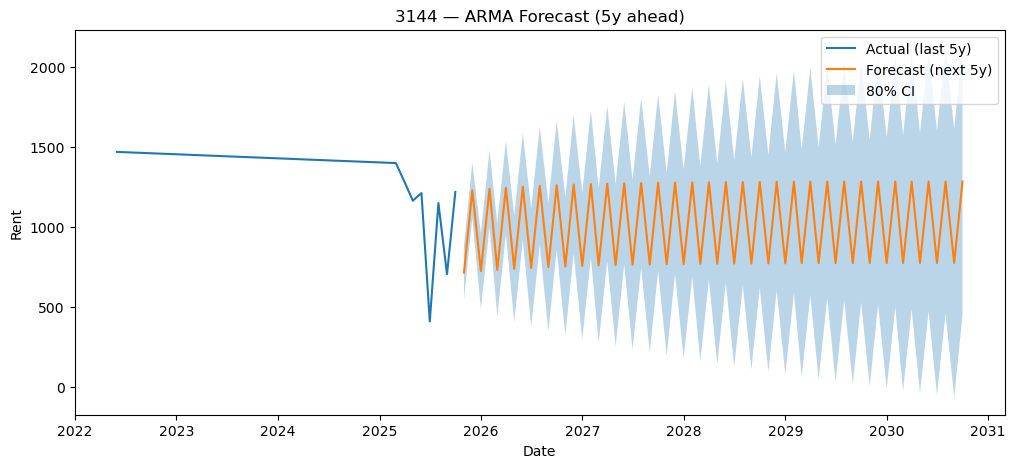

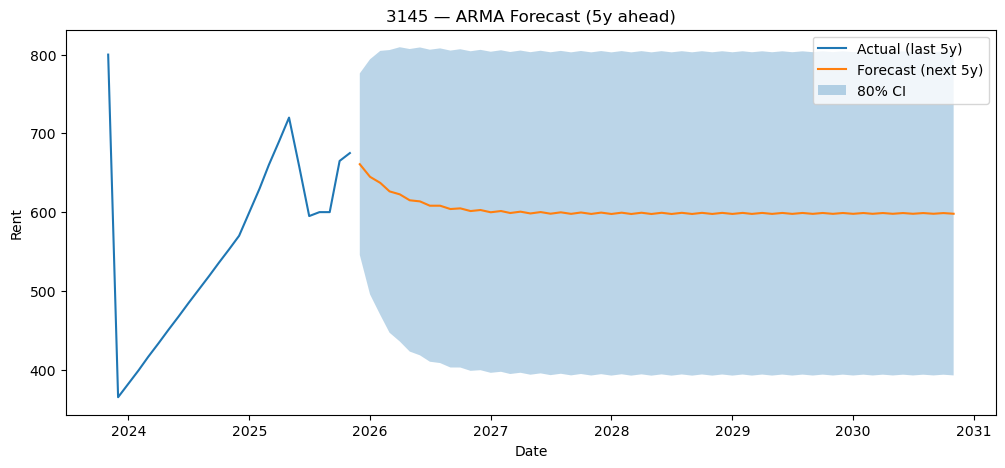

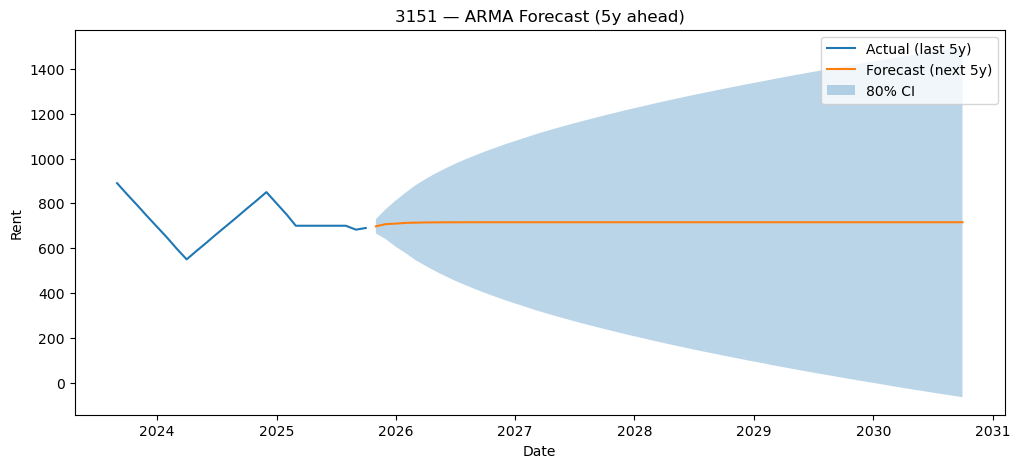

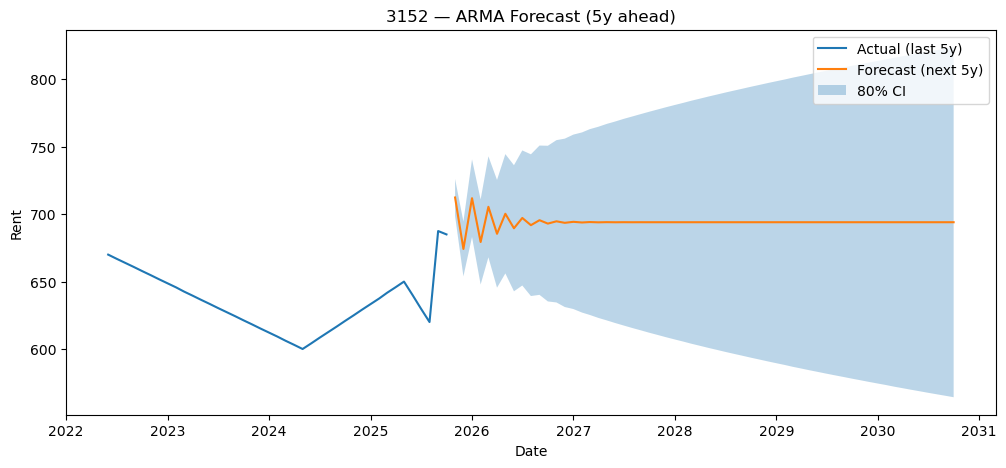

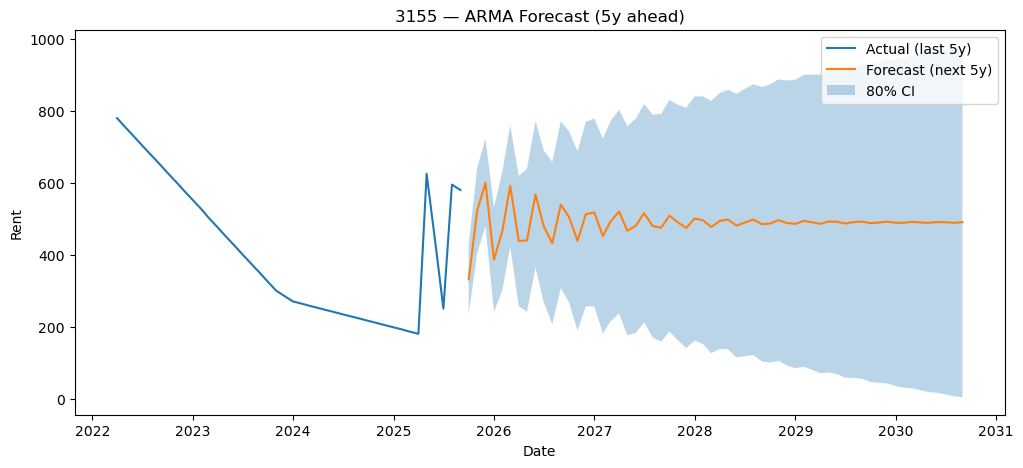

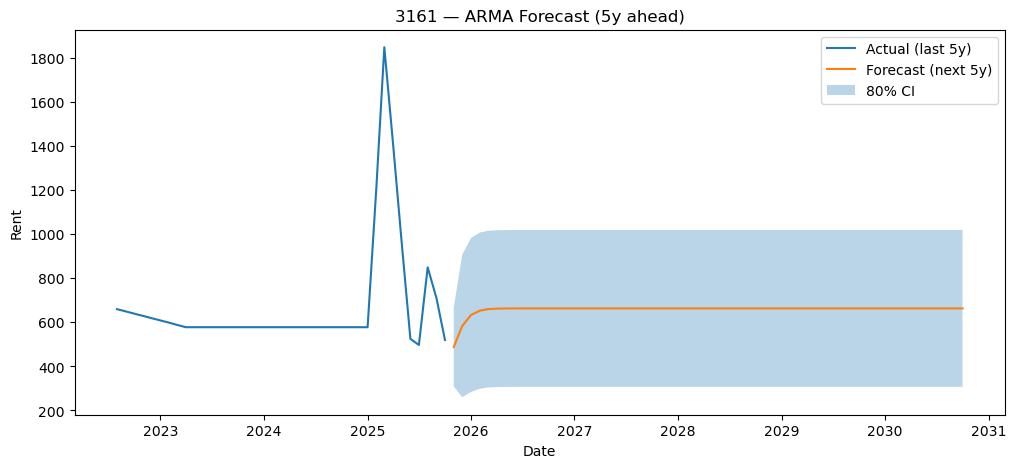

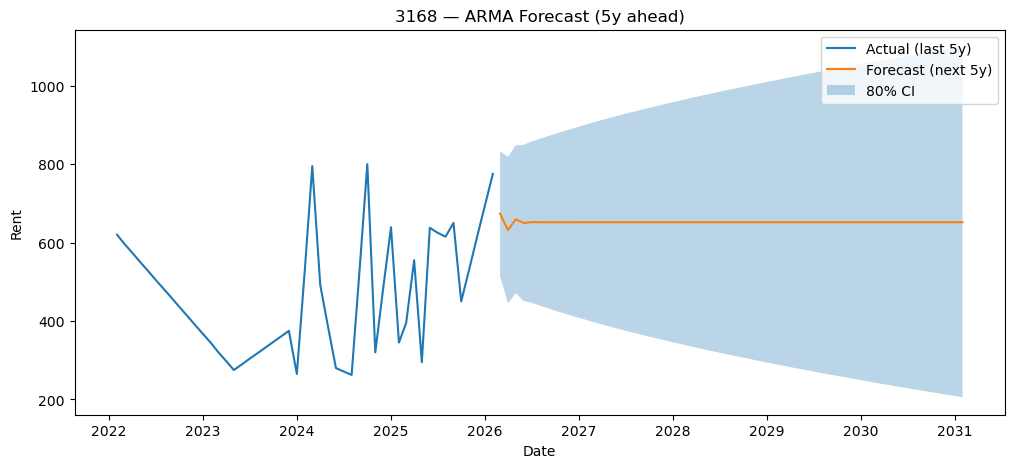

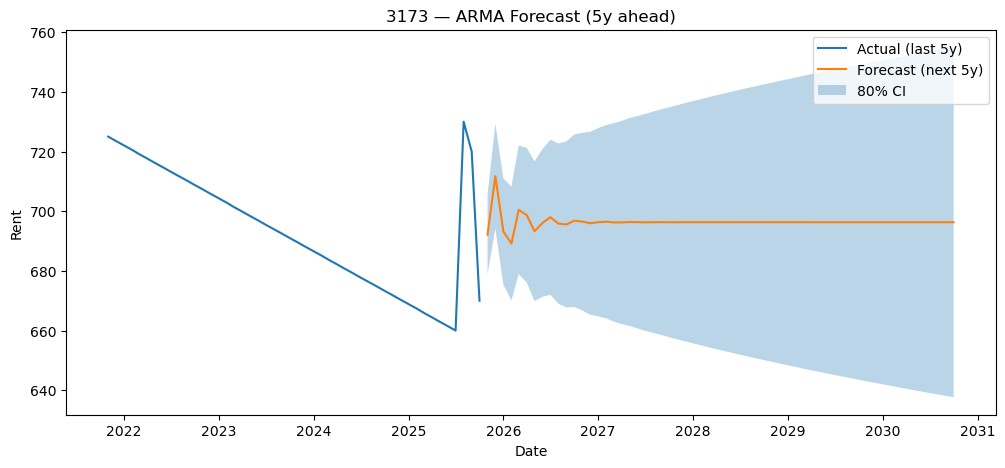

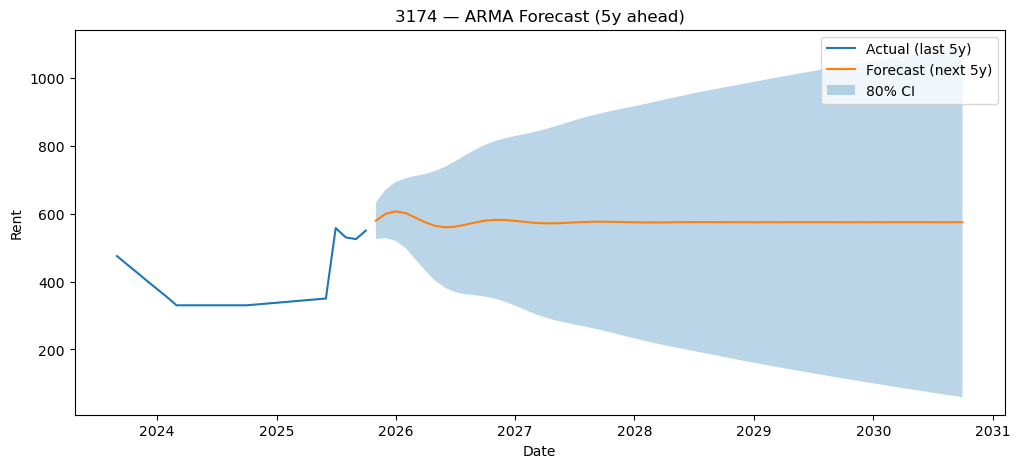

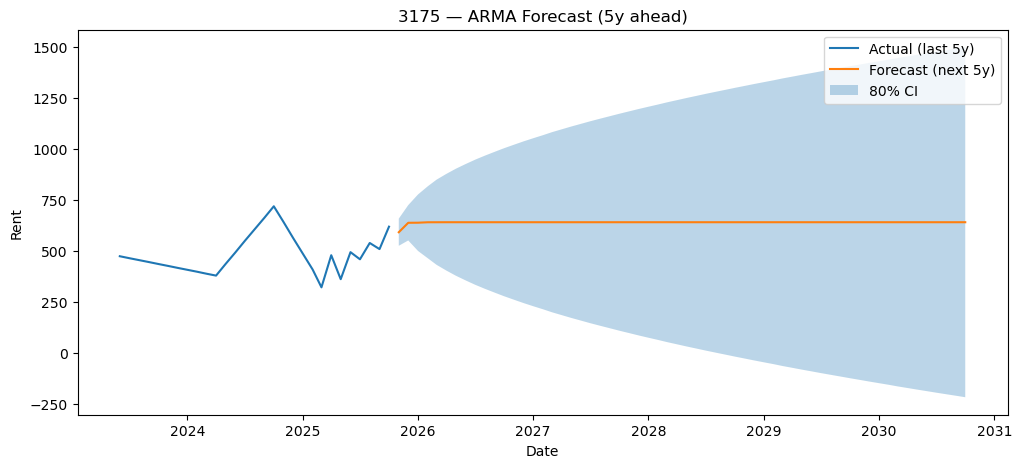

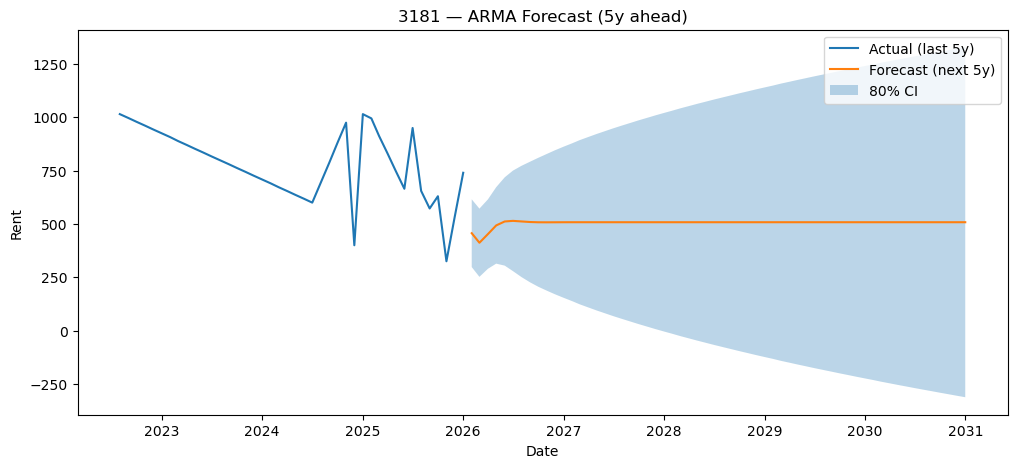

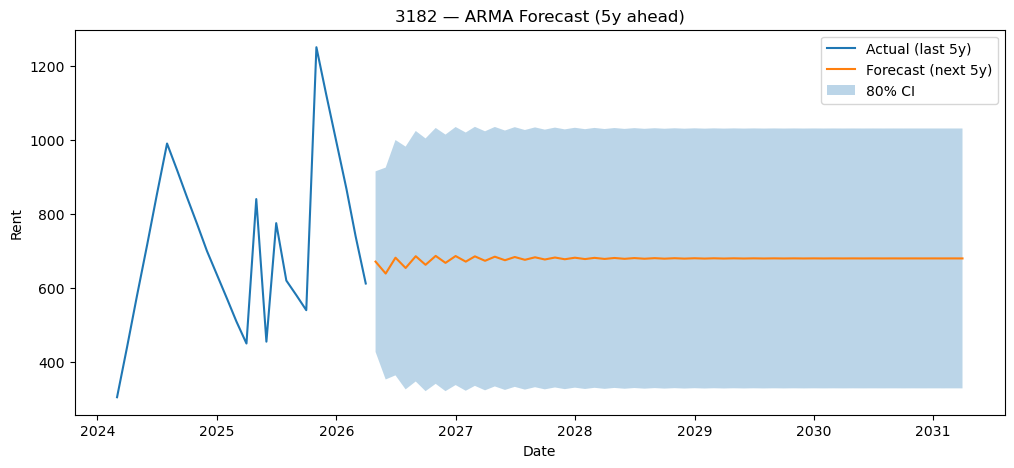

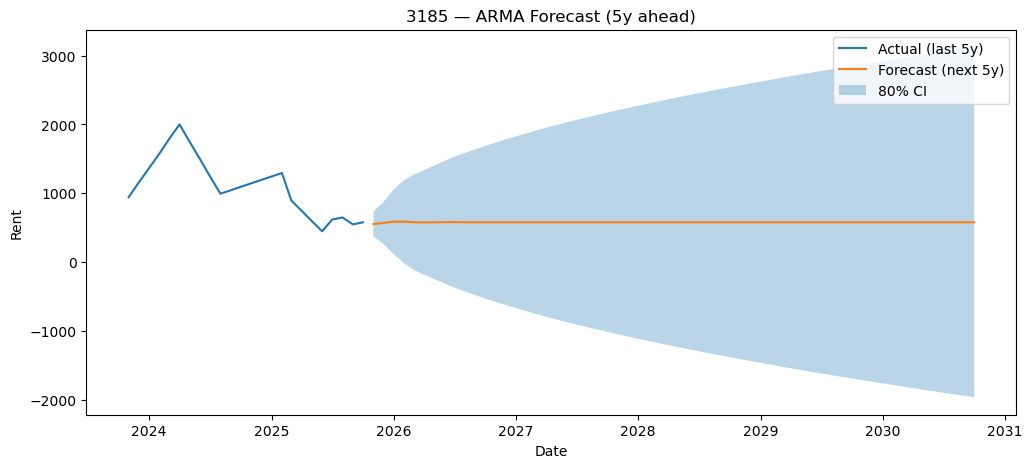

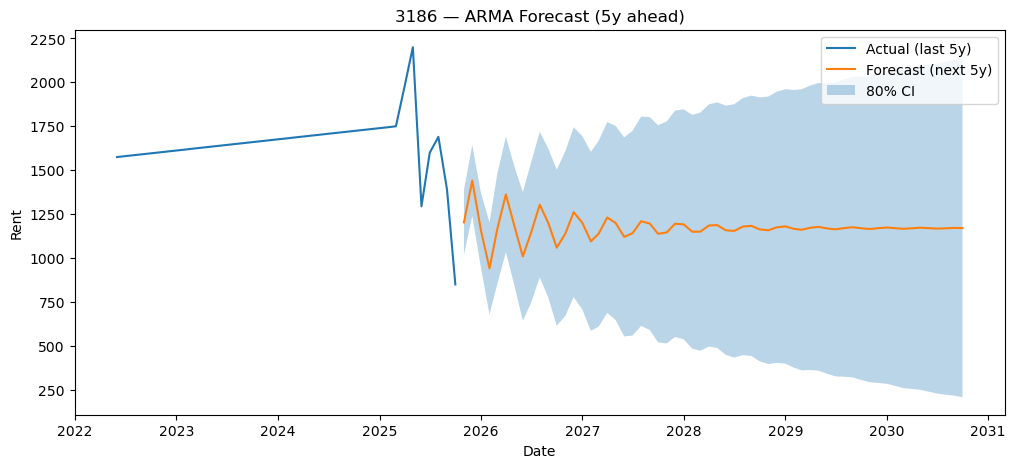

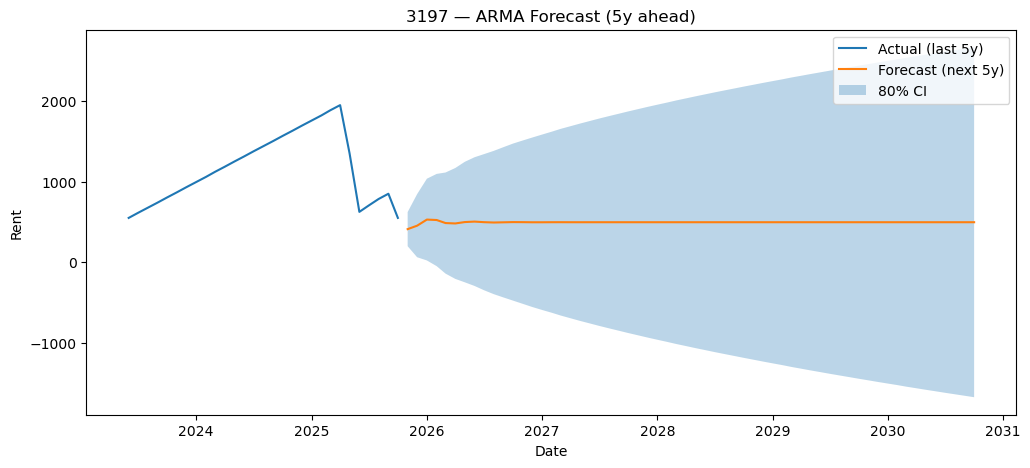

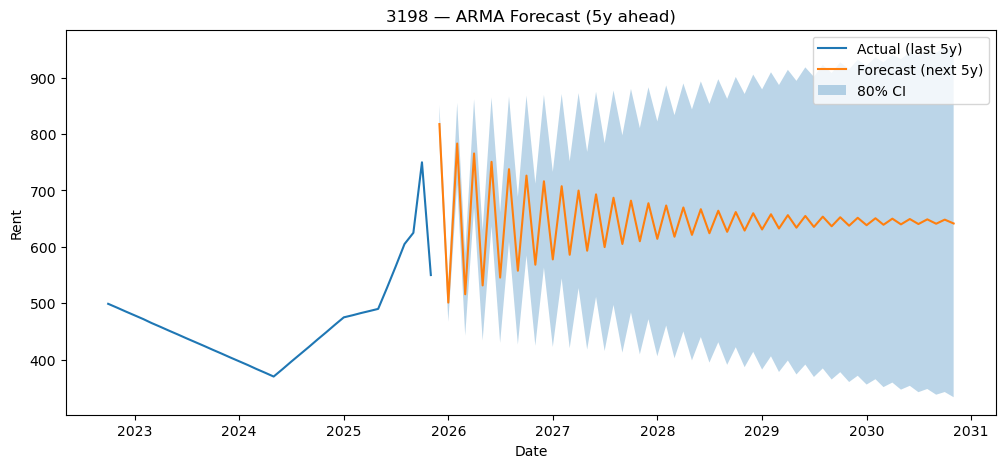

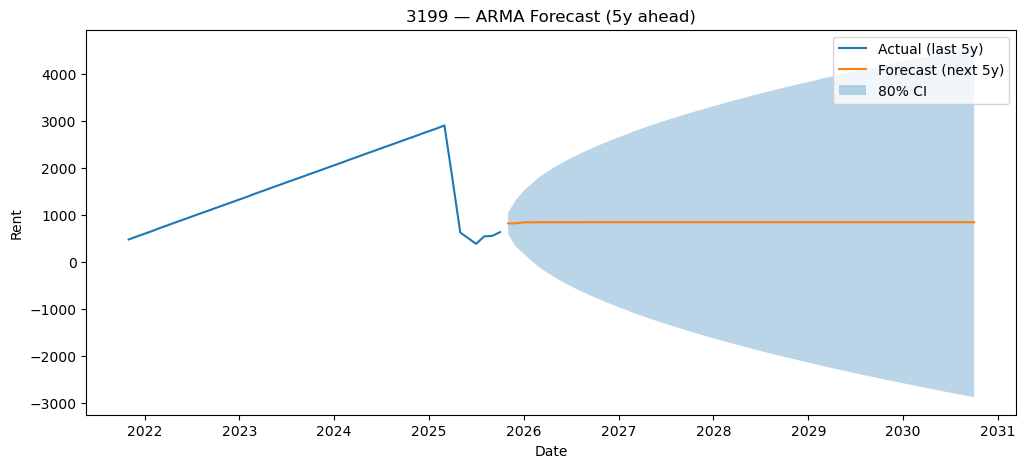

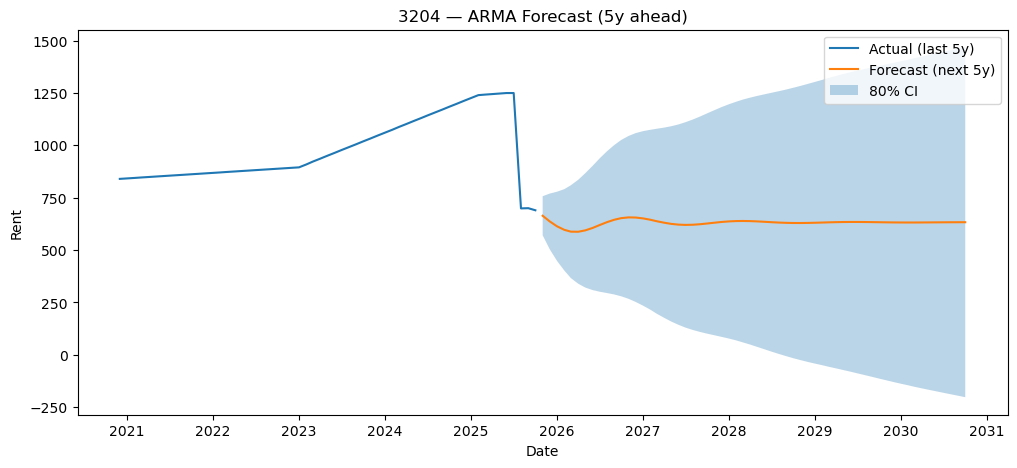

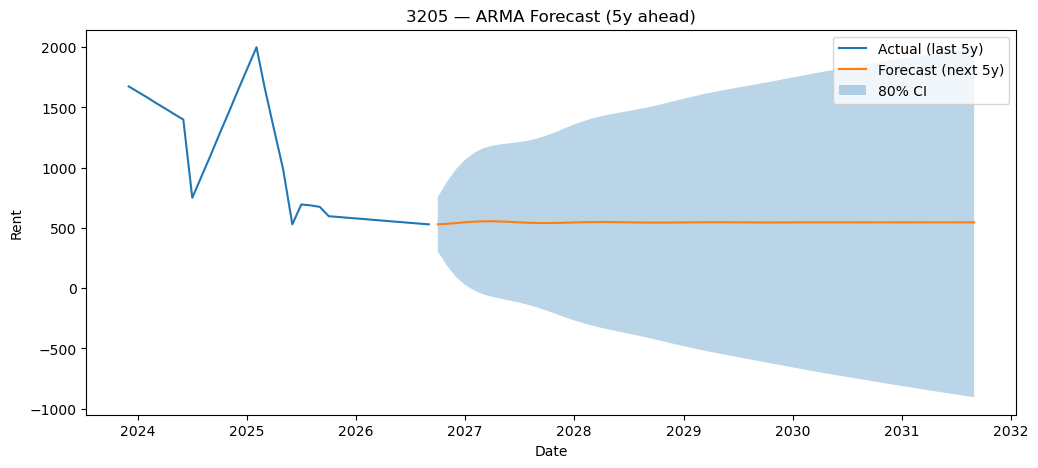

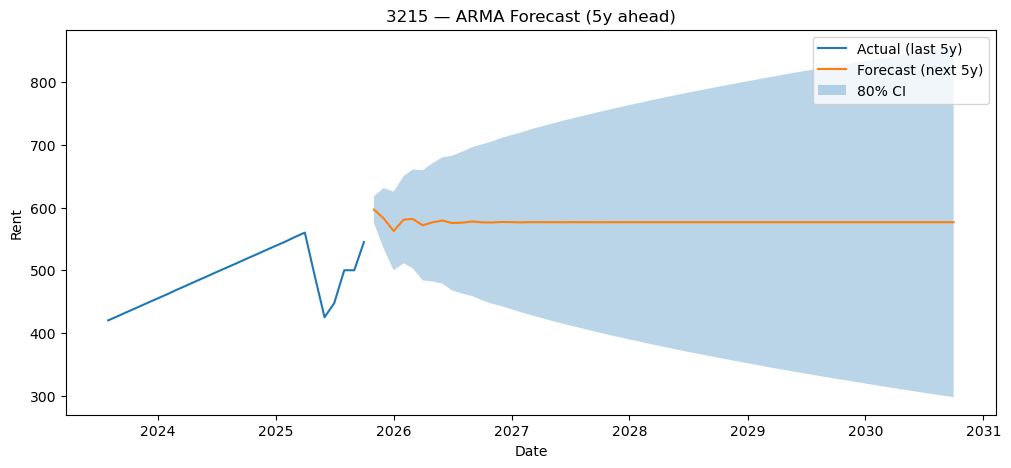

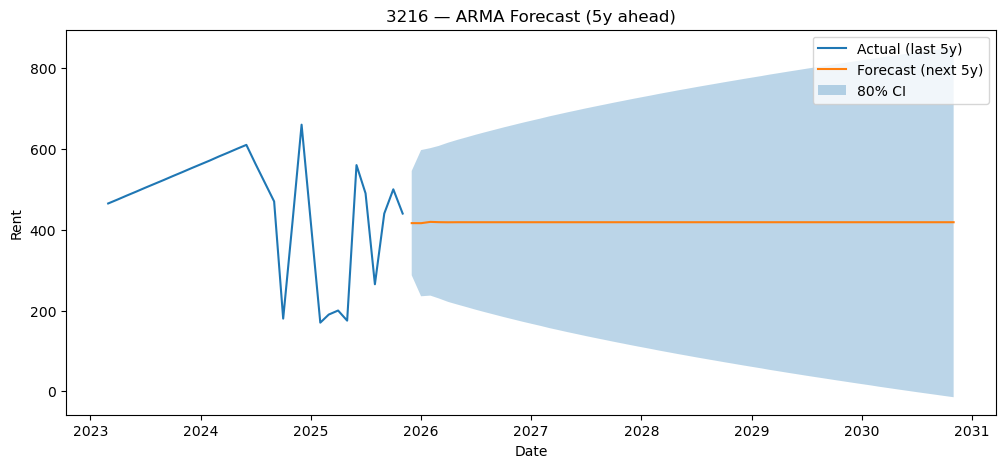

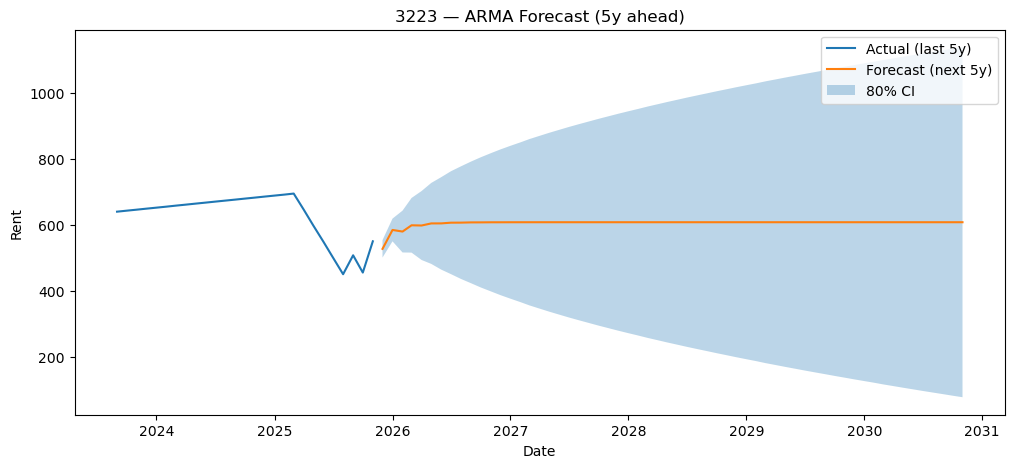

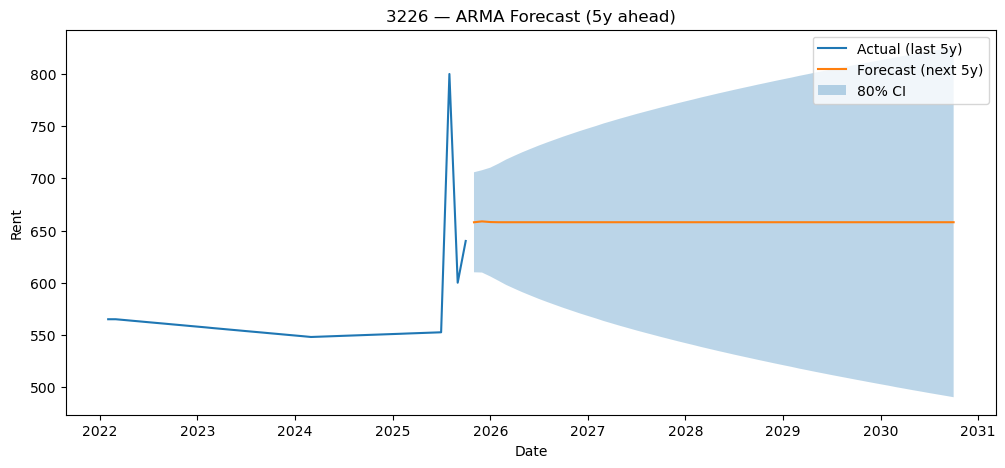

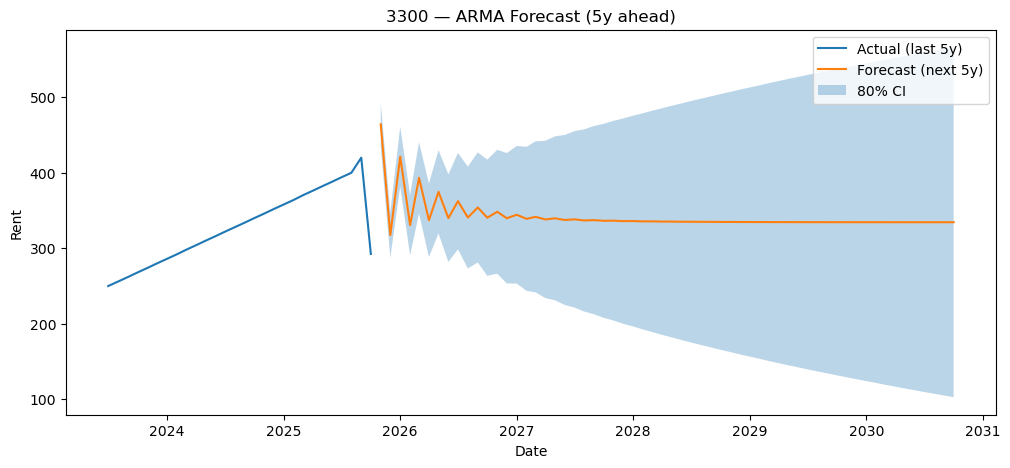

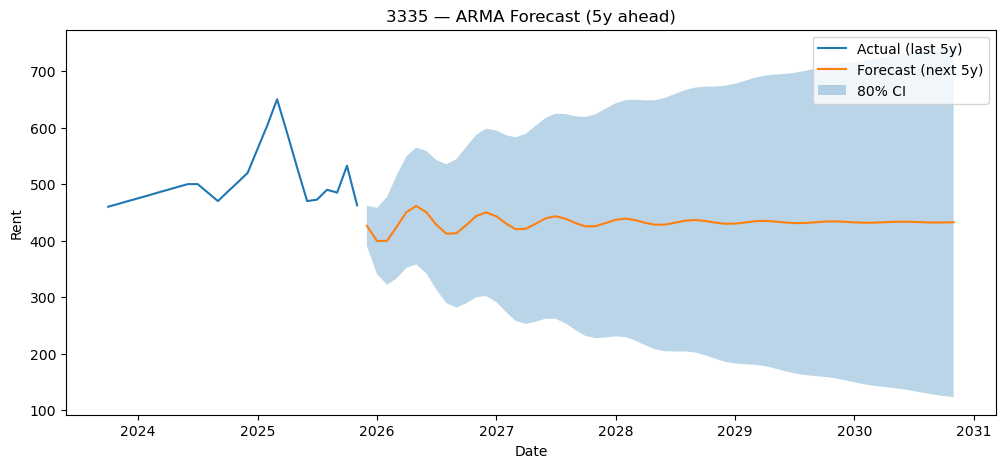

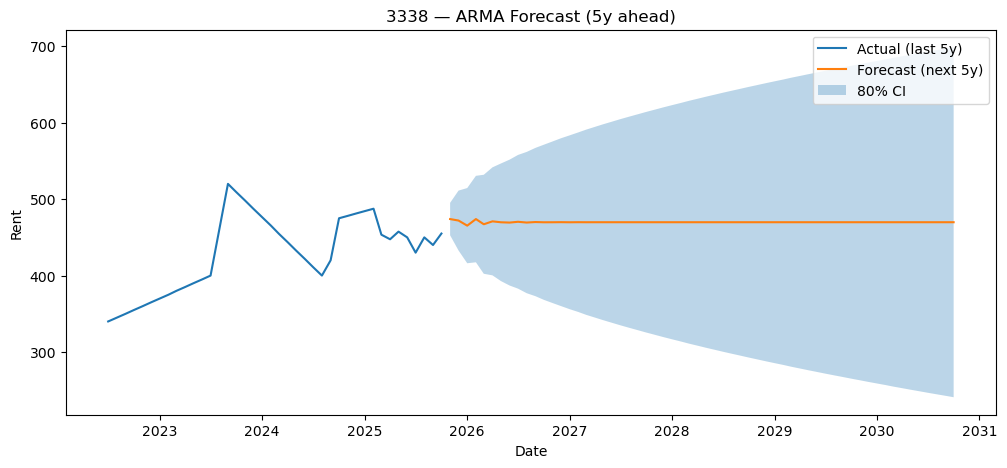

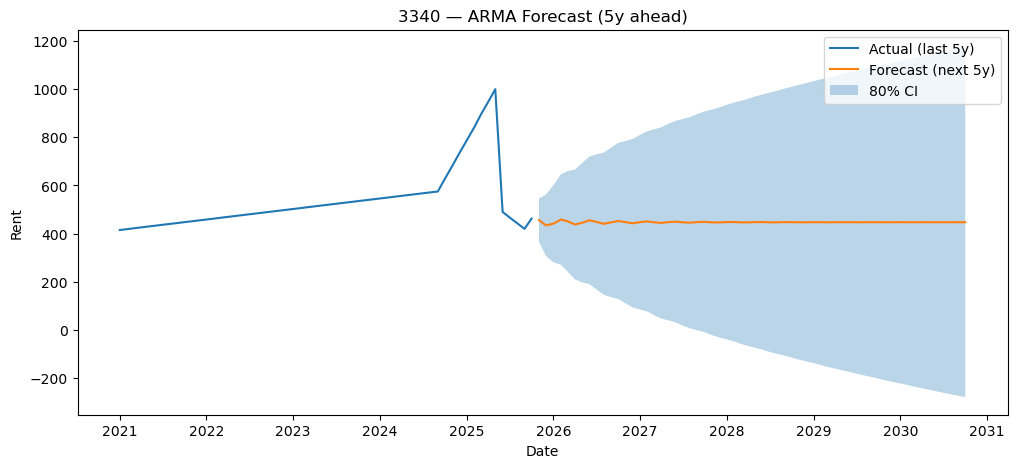

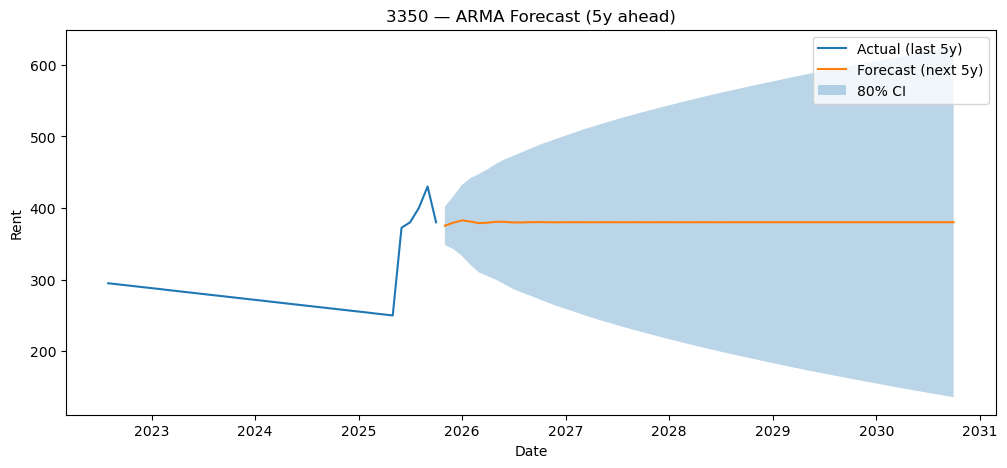

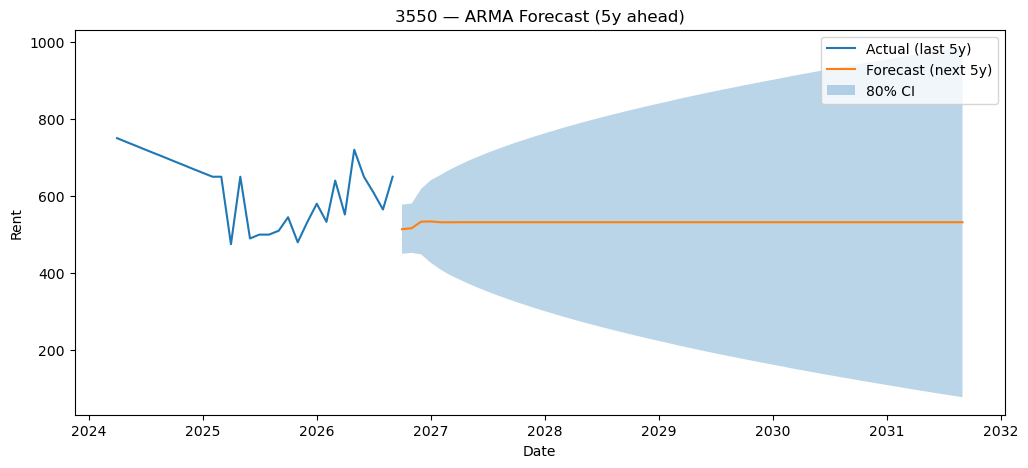

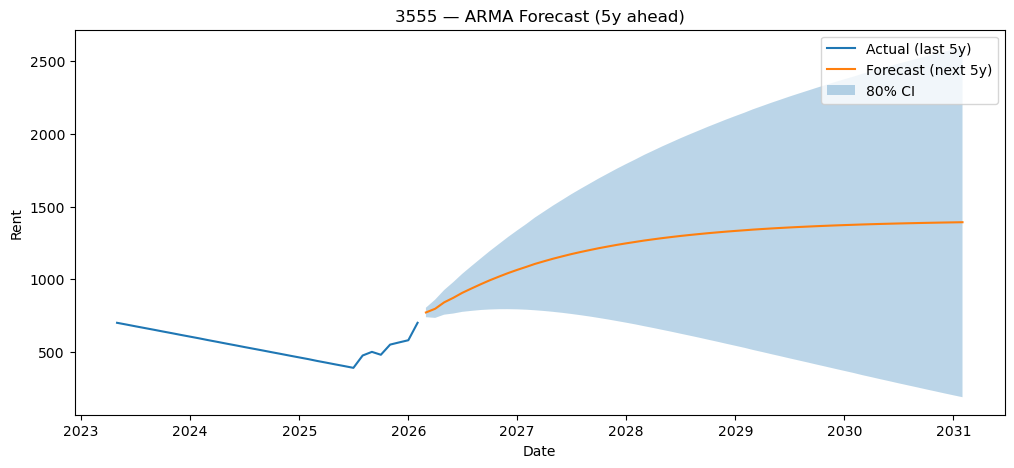

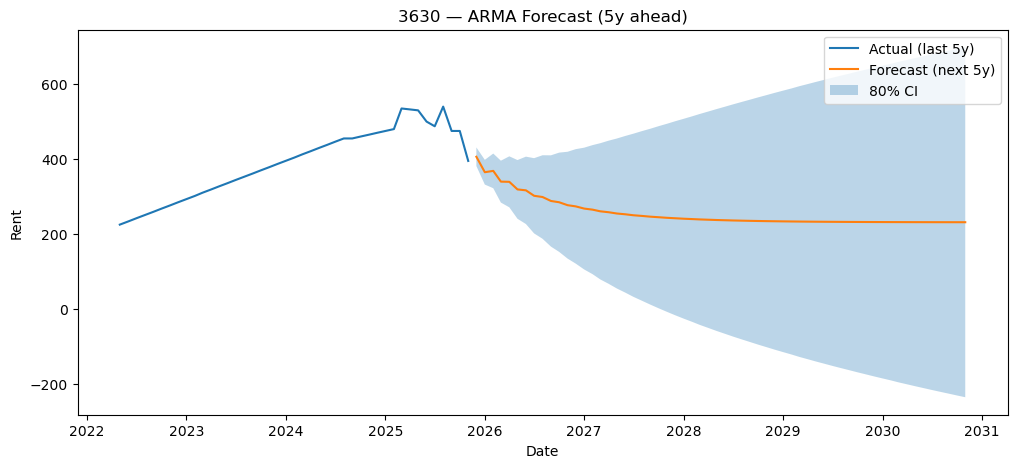

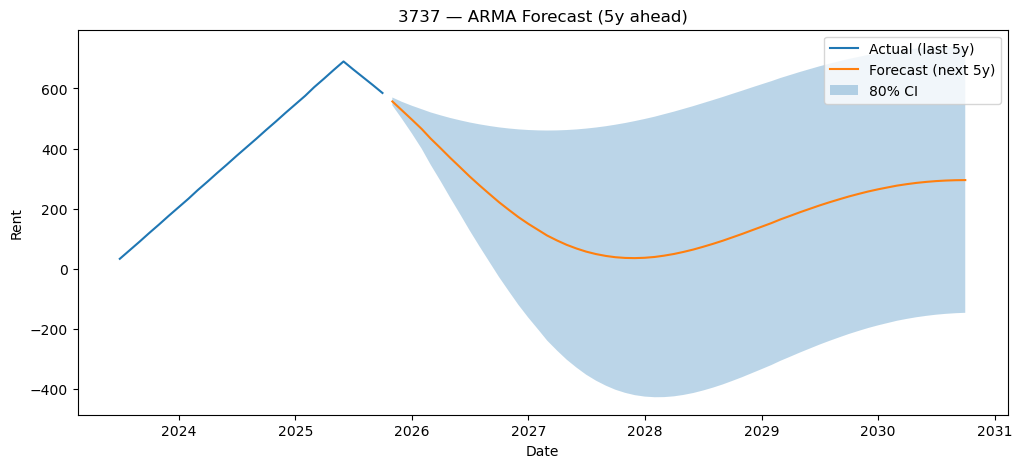

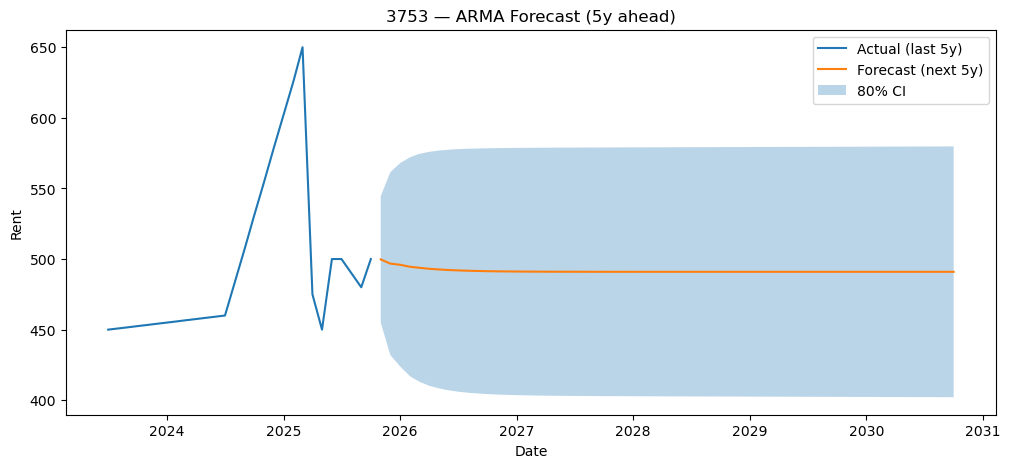

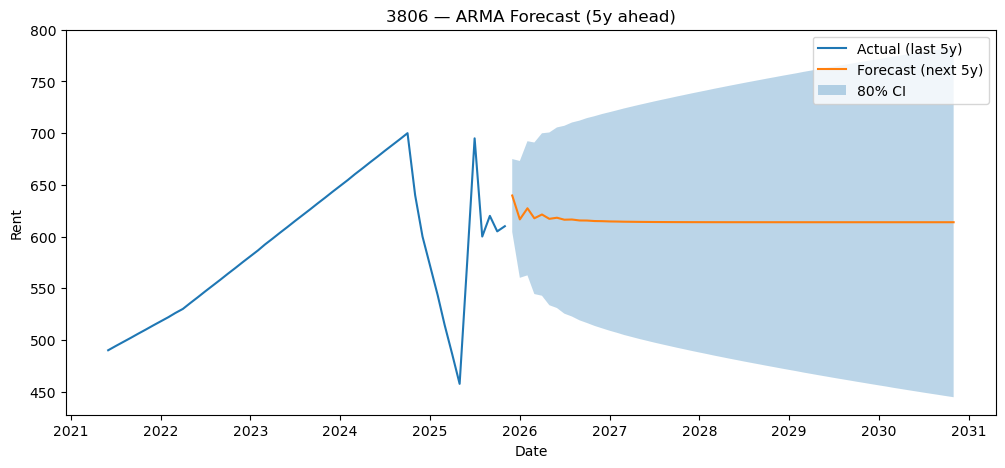

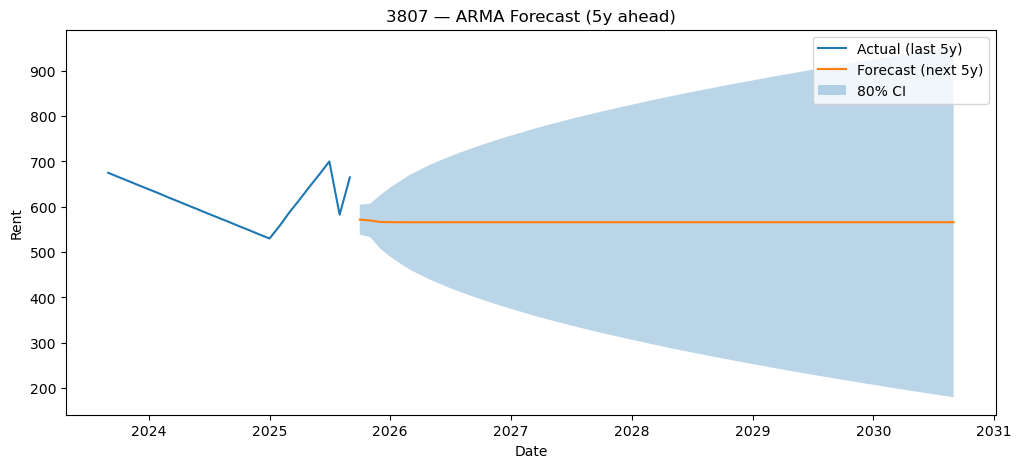

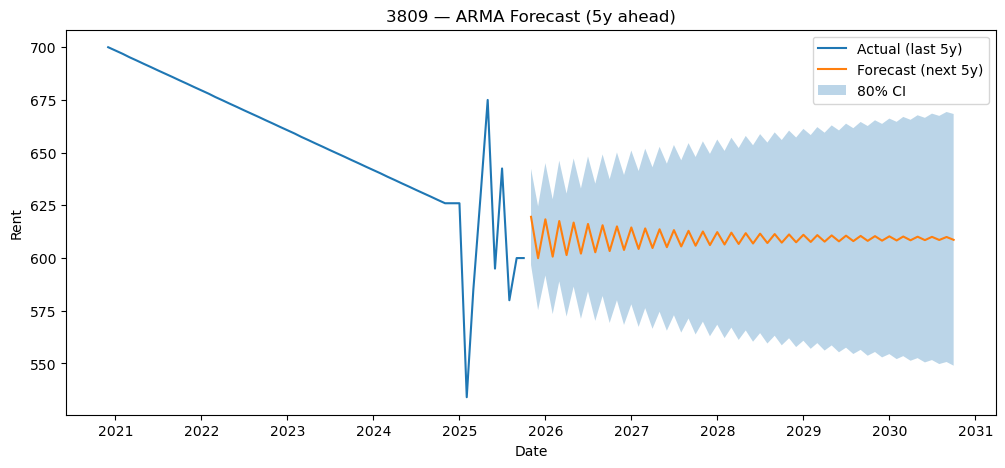

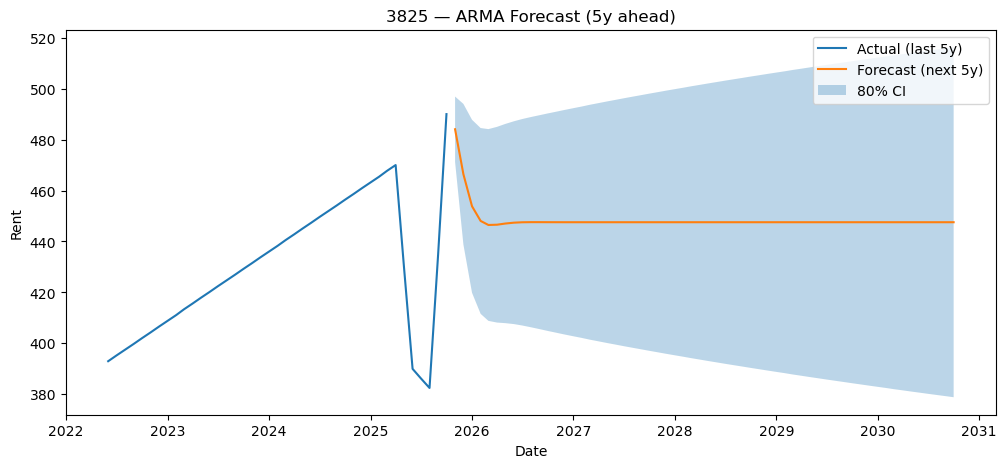

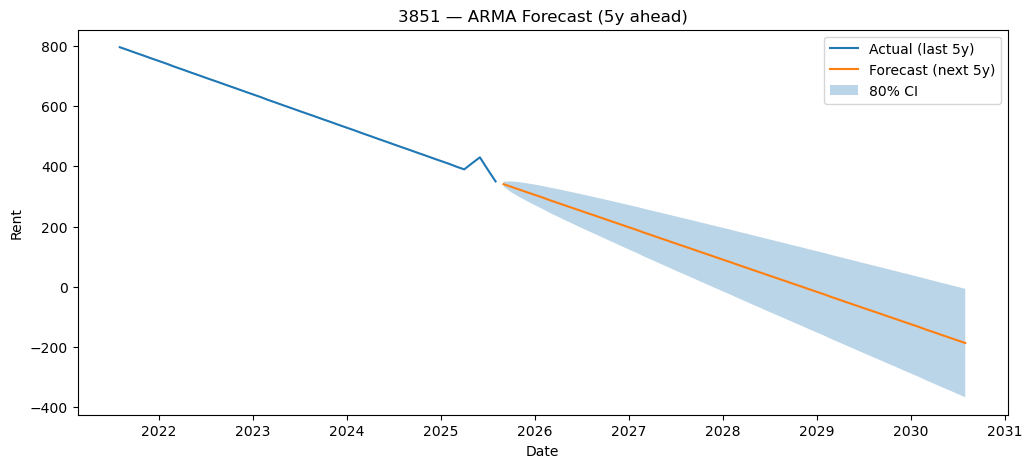

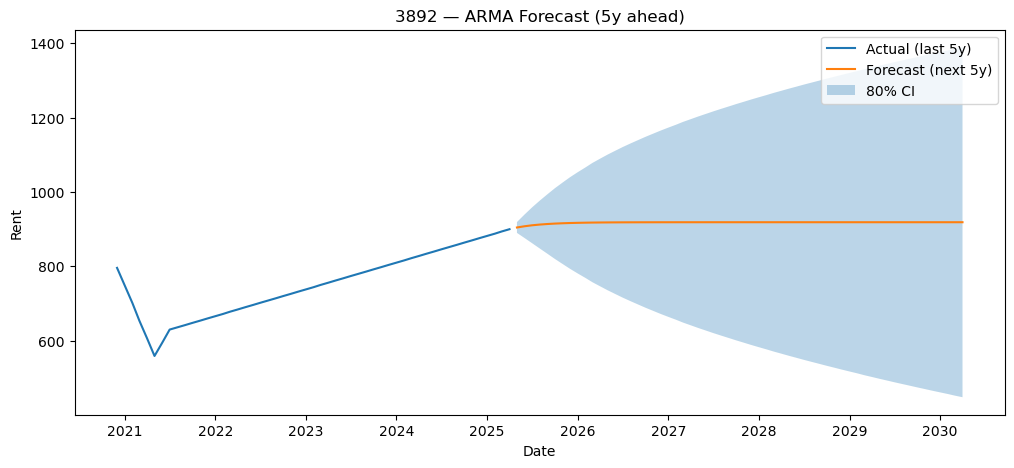

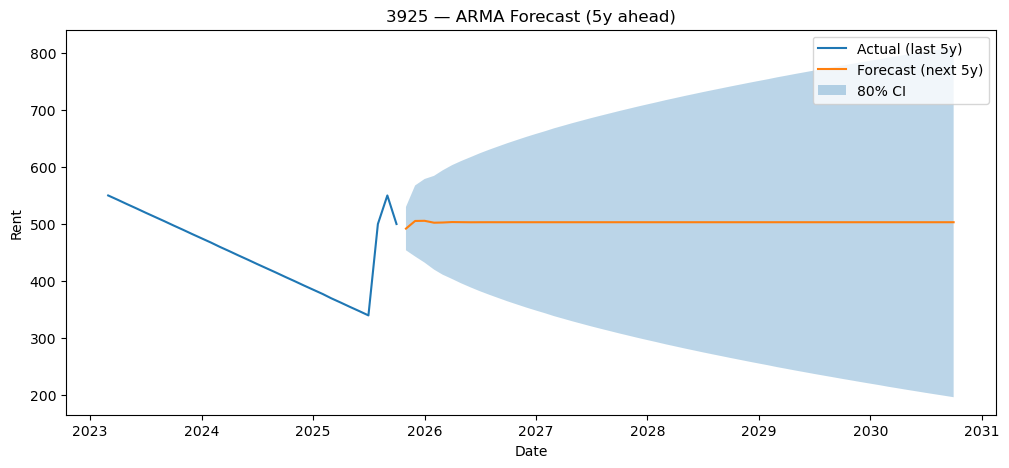

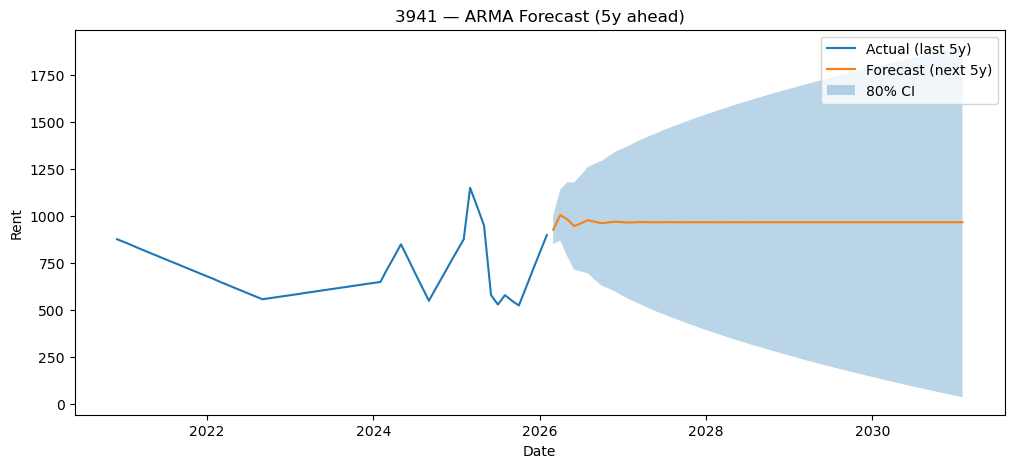

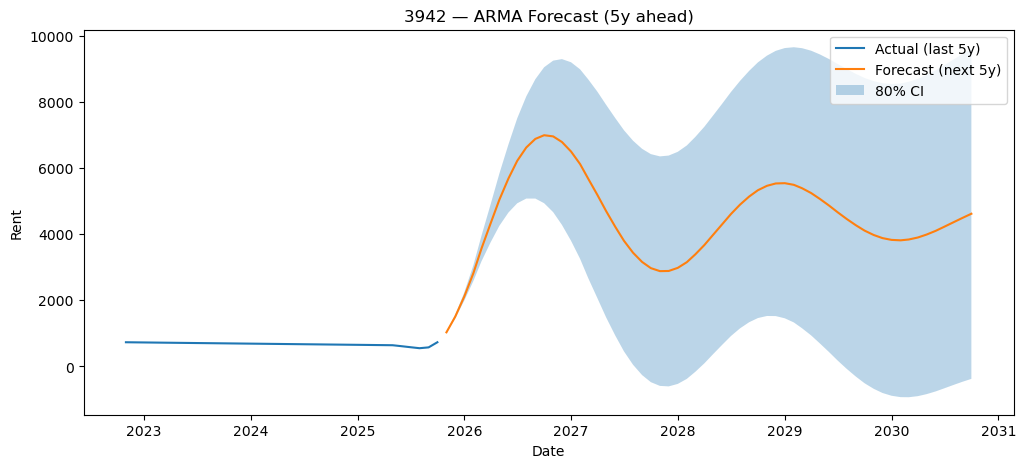

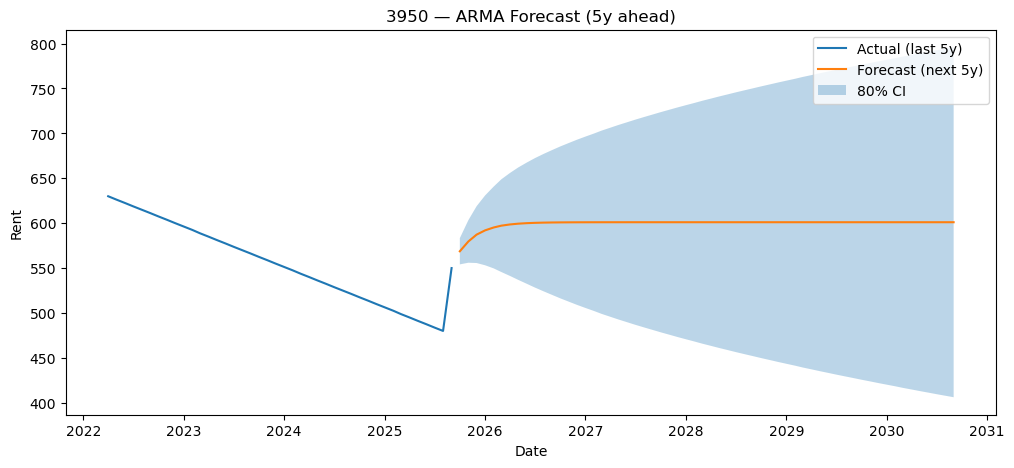

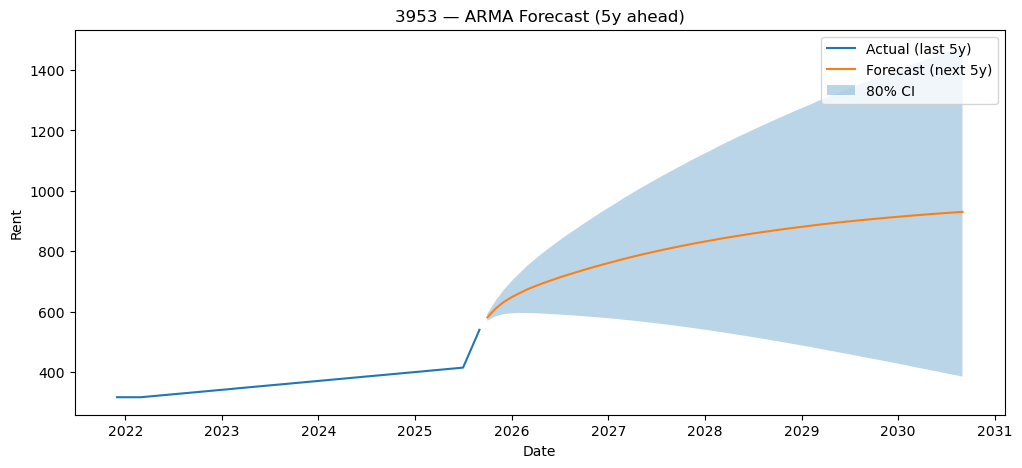

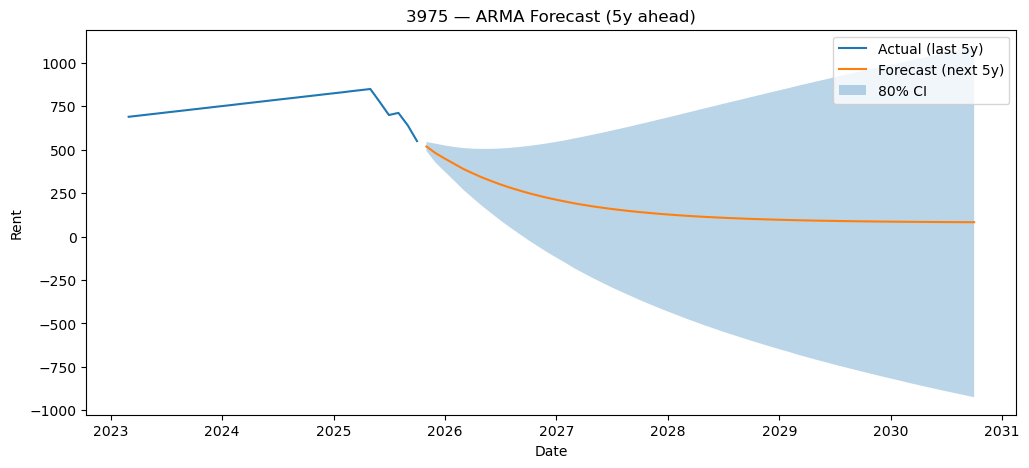

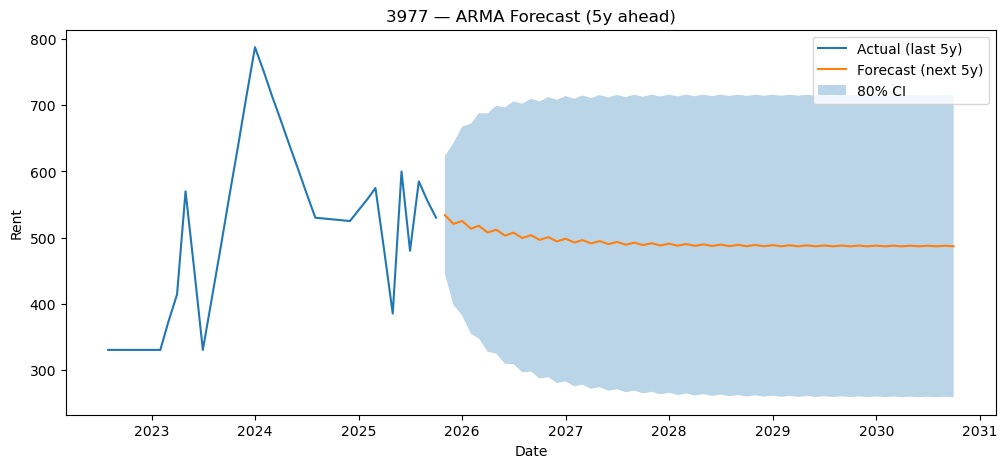

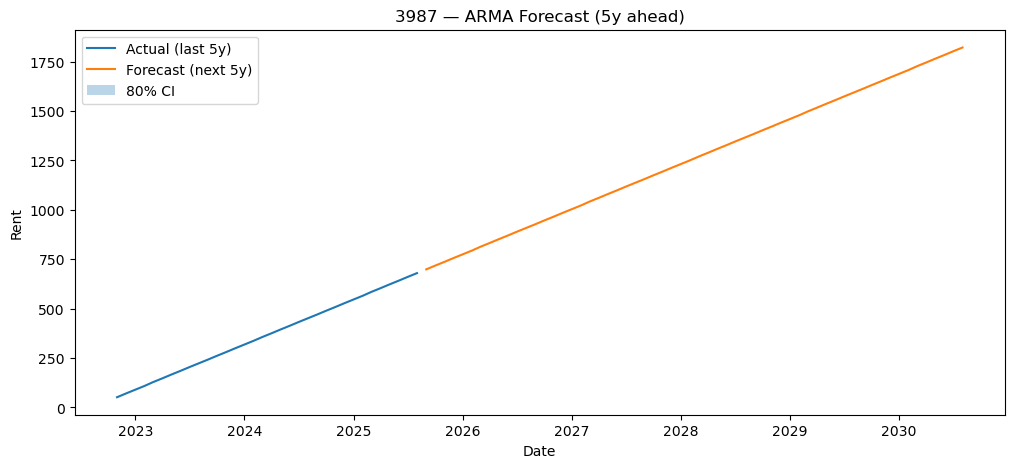

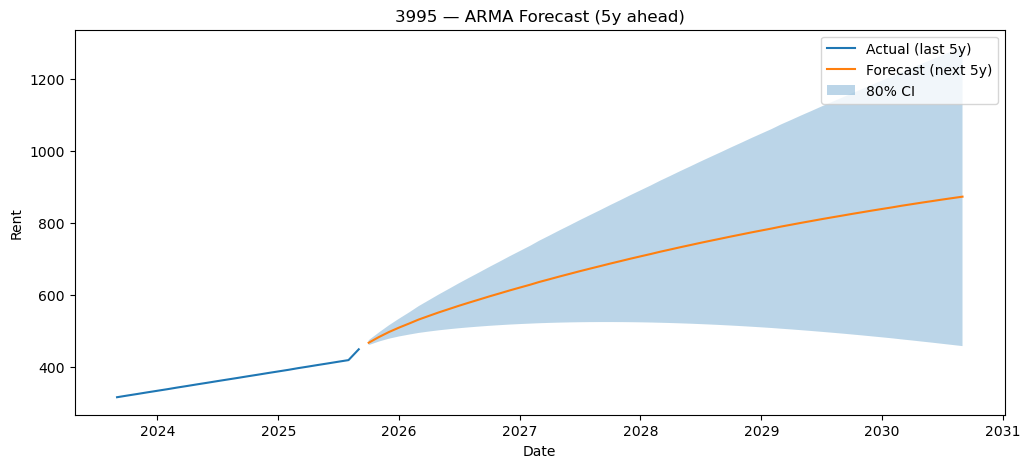

In [6]:
# No drift, can swap segment to see different forecast, regular ARIMA

# Parameters
CSV_PATH = "../../data/curated/cleaned_real_estate_data.csv"
TARGET_COL = "weekly_rent"
SEGMENT_COL = "postcode"   # None = global model
FREQ = "MS"                
TRAIN_YEARS = 5
FORECAST_YEARS = 5
FORECAST_HORIZON = FORECAST_YEARS * 12

# Helper Functions 
def build_date(df: pd.DataFrame) -> str:
    """Make a datetime column from available_year/month/day if needed."""
    if {"available_year","available_month"}.issubset(df.columns):
        year = pd.to_numeric(df["available_year"], errors="coerce").fillna(2000).astype(int)
        month = pd.to_numeric(df["available_month"], errors="coerce").fillna(1).astype(int).clip(1,12)
        day = pd.to_numeric(df.get("available_day", 1), errors="coerce").fillna(1).astype(int).clip(1,28)
        df["__date__"] = pd.to_datetime(dict(year=year, month=month, day=day), errors="coerce")
        return "__date__"
    for c in ["date","ds","month","period","as_of","reporting_month"]:
        if c in df.columns:
            return c
    raise ValueError("No usable date column found.")

def aggregate_monthly(df, date_col, target_col, segment_col=None):
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
    d = d.dropna(subset=[date_col, target_col])
    d[target_col] = pd.to_numeric(d[target_col], errors="coerce")
    d = d.dropna(subset=[target_col])
    d["__month__"] = d[date_col].values.astype("datetime64[M]")
    if segment_col:
        out = d.groupby([segment_col,"__month__"], as_index=False)[target_col].median()
        return out.rename(columns={"__month__":"ds", target_col:"y", segment_col:"segment"})
    else:
        out = d.groupby("__month__", as_index=False)[target_col].median()
        return out.rename(columns={"__month__":"ds", target_col:"y"})

def fit_arma(ts, p=2, q=2, log_transform = True):
    """Fit ARMA(p,q) → ARIMA(p,1,q) for trending data."""
    model = ARIMA(ts, order=(p,1,q))  
    return model.fit()

def forecast_with_ci(model, steps=60):
    fc = model.get_forecast(steps=steps)
    mean = fc.predicted_mean
    ci = fc.conf_int(alpha=0.2)  
    return mean, ci.iloc[:,0], ci.iloc[:,1]

def plot_series(history, yhat, lo, hi, title):
    plt.figure(figsize=(12,5))
    plt.plot(history.index, history.values, label="Actual (last 5y)")
    plt.plot(yhat.index, yhat.values, label="Forecast (next 5y)")
    plt.fill_between(yhat.index, lo.values, hi.values, alpha=0.3, label="80% CI")
    plt.title(title)
    plt.xlabel("Date"); plt.ylabel("Rent")
    plt.legend(); plt.show()

raw = pd.read_csv(CSV_PATH)
date_col = build_date(raw)
monthly = aggregate_monthly(raw, date_col, TARGET_COL, SEGMENT_COL)
cutoff = pd.Timestamp.today().normalize() - pd.DateOffset(years=TRAIN_YEARS)
monthly = monthly[monthly["ds"] >= cutoff]

# Train & Forecast 
if SEGMENT_COL:
    for seg in monthly["segment"].dropna().unique():
        ts = monthly[monthly["segment"]==seg].set_index("ds")["y"].asfreq(FREQ).interpolate()
        if ts.shape[0] < 24: continue
        model = fit_arma(ts, p=2, q=2)
        yhat, lo, hi = forecast_with_ci(model, FORECAST_HORIZON)
        plot_series(ts, yhat, lo, hi, f"{seg} — ARMA Forecast (5y ahead)")
else:
    ts = monthly.set_index("ds")["y"].asfreq(FREQ).interpolate()
    model = fit_arma(ts, p=2, q=2)
    yhat, lo, hi = forecast_with_ci(model, FORECAST_HORIZON)
    plot_series(ts, yhat, lo, hi, "Global — ARMA Forecast (5y ahead)")

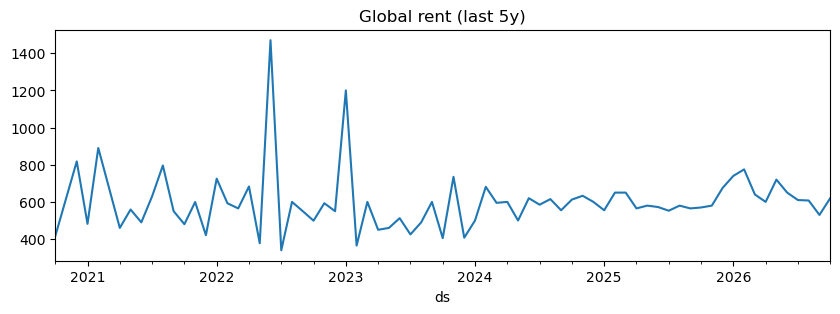

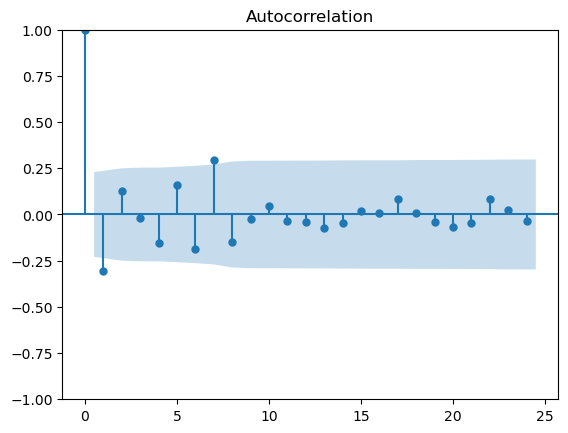

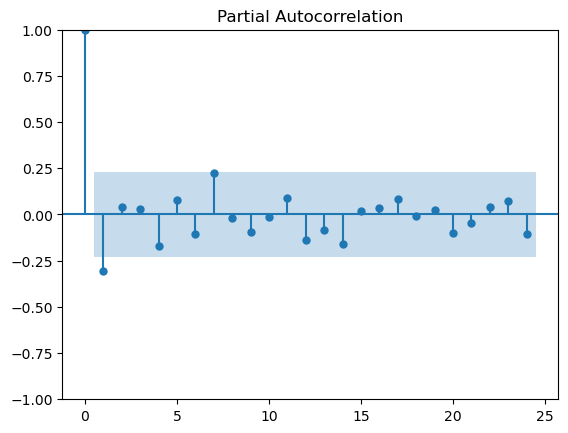

In [7]:
# Check statistics
ts = (
    monthly.groupby("ds")["y"]
    .median()
    .asfreq("MS")
    .interpolate()
)

plt.figure(figsize=(10,3))
ts.plot(title="Global rent (last 5y)")
plt.show()

plot_acf(ts.dropna(), lags=24)
plt.show()

plot_pacf(ts.dropna(), lags=24, method="ywm")
plt.show()

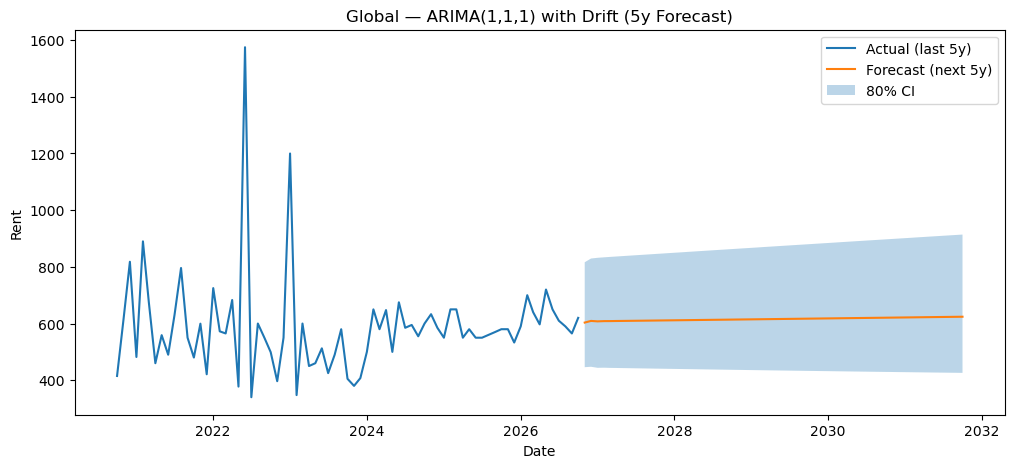

In [8]:
# Parameters
CSV_PATH = "../../data/curated/cleaned_real_estate_data.csv"  
TARGET_COL = "weekly_rent"                
FREQ = "MS"                               
TRAIN_YEARS = 5
FORECAST_YEARS = 5
FORECAST_HORIZON = FORECAST_YEARS * 12

# Helper functions
def build_date(df: pd.DataFrame) -> str:
    if {"available_year","available_month"}.issubset(df.columns):
        year = pd.to_numeric(df["available_year"], errors="coerce").fillna(2000).astype(int)
        month = pd.to_numeric(df["available_month"], errors="coerce").fillna(1).astype(int).clip(1,12)
        day = pd.to_numeric(df.get("available_day", 1), errors="coerce").fillna(1).astype(int).clip(1,28)
        df["__date__"] = pd.to_datetime(dict(year=year, month=month, day=day), errors="coerce")
        return "__date__"
    for c in ["date","ds","month","period","as_of","reporting_month"]:
        if c in df.columns:
            return c
    raise ValueError("No usable date column found.")

def aggregate_monthly(df, date_col, target_col):
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
    d = d.dropna(subset=[date_col, target_col])
    d[target_col] = pd.to_numeric(d[target_col], errors="coerce")
    d = d.dropna(subset=[target_col])
    d["__month__"] = d[date_col].values.astype("datetime64[M]")
    out = d.groupby("__month__", as_index=False)[target_col].median()
    return out.rename(columns={"__month__":"ds", target_col:"y"})

def fit_arima_with_drift(ts, p=1, d=1, q=1, log_transform=True):
    y = np.log1p(ts) if log_transform else ts
    # use linear trend 't' when d=1 → acts like drift
    model = ARIMA(y, order=(p,d,q), trend="t")
    res = model.fit()
    return res, log_transform

def forecast_and_invert(model, steps=60, log_transform=True):
    fc = model.get_forecast(steps=steps)
    mean = fc.predicted_mean
    ci = fc.conf_int(alpha=0.2)  # 80% CI
    lo, hi = ci.iloc[:,0], ci.iloc[:,1]
    if log_transform:
        mean = np.expm1(mean)
        lo   = np.expm1(lo)
        hi   = np.expm1(hi)
    return mean, lo, hi

def plot_series(history, yhat, lo, hi, title):
    plt.figure(figsize=(12,5))
    plt.plot(history.index, history.values, label="Actual (last 5y)")
    plt.plot(yhat.index, yhat.values, label="Forecast (next 5y)")
    plt.fill_between(yhat.index, lo.values, hi.values, alpha=0.3, label="80% CI")
    plt.title(title)
    plt.xlabel("Date"); plt.ylabel("Rent")
    plt.legend(); plt.show()

raw = pd.read_csv(CSV_PATH)
date_col = build_date(raw)
monthly = aggregate_monthly(raw, date_col, TARGET_COL)
cutoff = pd.Timestamp.today().normalize() - pd.DateOffset(years=TRAIN_YEARS)
monthly = monthly[monthly["ds"] >= cutoff]

# Train & forecast
ts = monthly.set_index("ds")["y"].asfreq(FREQ).interpolate()
res, log_used = fit_arima_with_drift(ts, p=1, d=1, q=1, log_transform=True)
yhat, lo, hi = forecast_and_invert(res, steps=FORECAST_HORIZON, log_transform=log_used)

plot_series(ts, yhat, lo, hi, "Global — ARIMA(1,1,1) with Drift (5y Forecast)")